# N006 ベジエ曲線のあてはめ

In [1]:
import sys,os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
import numpy as np
import matplotlib.pyplot as plt
import cv2
import platform

# from sympy import *
from sympy import diff,Symbol,Matrix,symbols,solve,simplify,binomial,lambdify
from sympy.abc import a,b,c
# init_session()
from sympy import var
# px,py =var('px:4'),var('py:4')

# Google Colaboratory の MyDrive パス
COLABRDROOT = "/content/drive/MyDrive/RadiShLab"

# ホーム
LOCALHOME = "."  # フォルダを絶対指定するならここを書き変えてください

# 環境判定（Google Colaboratory かどうかの判定）
try:
    from google.colab import drive
    drive.mount('/content/drive')
    sys.path.append(COLABRDROOT+'/rdlib')
    COLABORATORY = True
except ImportError:
    sys.path.append('./rdlib')
    COLABORATORY = False
    if platform.system()=='Windows':
        os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
#import rdlib8 as rd
import rdexper as rd

# フォルダ指定
labhome = COLABRDROOT if COLABORATORY else LOCALHOME
resdir = "/res/windows" if platform.system() == "Windows" else "/res"

NSilF = labhome+'/RDSamples/NSilImages' # 正規化されたシルエット画像のフォルダ
imgs = rd.collectimages(NSilF)       # シルエット画像のリスト

輪郭線の画素数は、左 312  右309


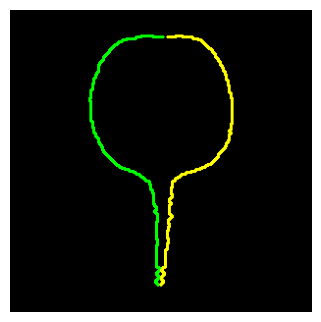

In [2]:
# 画像の左右の輪郭線を抽出　（N005参照）
img = imgs[4]
conLeft,conRight = rd.getCntPairWithImg(img,dtopdr=1,dbtmdr=1)
canvas = cv2.cvtColor(np.zeros_like(img) ,cv2.COLOR_GRAY2BGR)
rd.drawContours(canvas,conLeft,color=(0,255,0),thickness=2)
rd.drawContours(canvas,conRight,color=(0,255,255),thickness=2)
plt.figure(dpi=100)
rd.plotimg(canvas)
print("輪郭線の画素数は、左 {}  右{}".format(len(conLeft),len(conRight)))

輪郭線を構成する画素の数は、この例で左右それぞれ300画素近い。

## **getSamples()**
> **rd.getSamples(cont,N=20,mode='Equidistant')**  
    > 入力  
    > 　**cont** 輪郭線構造体 開いた輪郭線を想定している  
    > 　**N** サンプル数  
    > パラメータ  
    >　 **mode = 'Equidistant'**  始点からの距離について等間隔 (default)  
    > 　**mode = 'Simple'**  単純にインデックスを等間隔

ディジタル画像は斜め方向と上下左右とで画素間の距離が異なるので、単純にインデックスを等間隔に刻むと、輪郭が斜めになっている部分と縦横に伸びている部分とでサンプリング間隔が変化してしまう。

曲線あてはめにはそれほど影響しないが、気にする場合は **Equidistant**を用いるとよい。

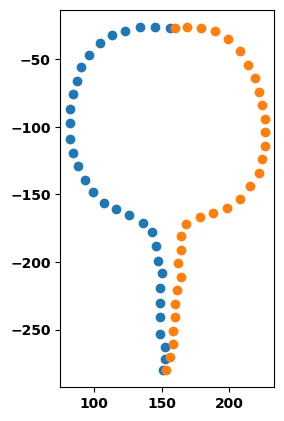

In [3]:
Left = rd.getSamples(conLeft,N=32,mode='Equidistant')
Right = rd.getSamples(conRight,N=32,mode='Simple')

plt.figure(figsize=(5,5),dpi=100)
g = plt.subplot()
g.set_aspect('equal')
plt.scatter(Left[:,0],-Left[:,1])
plt.scatter(Right[:,0],-Right[:,1]);

左が距離等間隔、右がインデックスの等間隔

# ベジエ曲線のあてはめ

- 標本点 $samples[i]$ と同じ数だけの点をベジエ曲線上に設定し、たがいを紐づける。ベジエ曲線上の点$P[i]$はパラメータ $t[i]$ だけで特定される。つまり、$P[i]=Bez(t[i])$ と書ける。
- 目的関数を$\|samples[i]-Bez[t[i]]\|$とし、これを最小化するような 関数$Bez()$を見つけることが目的である。
- ベジエ曲線は$N+1$個の制御点で規定されるので、もし $t[i]$ が既知であるならば、未知数　$2(N+1)$個 の最適化問題である。しかし、実際には $t[i]$ はわからない。
- 逆にベジエ曲線の制御点が分かっているならば、未知数は $t[i]$ であり、ベジエ曲線上で各標本点の最寄りの点を探す問題となる。
- 実際にはいずれも未知であるのですべて連立させて最適化しないといけないが一度に求める解析的な方法はありそうにない。そこで、ここでは緩和法的なアルゴリズムを用いて解決する。

### 漸近的ベジエフィッティングアルゴリズム

> **fit0()**  
> パラメータを固定して評価関数が最小化されるような制御点を求めることで、暫定的なベジエ近似曲線の表現式を得るプログラム   

> **fit1()**  
> fit0() と refineTparaN() を繰り返すことでフィッティングを行うプログラム。

> **fit1T()**
> fit1() の tensorflow による実装

> **fit2()**   
> 十分近似がうまくいくまで、次数を段階的に増やしていくプログラム

>> mode 0    fit1
>> mode 1    fitT1 mode 1
>> mode 2    fitT1 mode 0 

以上の関数を持つクラス、BezierCurve を用意した。

---

## class BezierCurve:
> クラス変数  
>> **driftThres** = 0.03 # 繰り返しの終了を決定するパラメータ変動幅の平均値に対するしきい値  
>> **errorThres** = 0.01  # 繰り返しの終了を決定するエラー変動のしきい値  
>> **dCount** = 5        # ２分探索の打ち切り回数  
>> **debugmode** = False  # デバッグ情報の表示オンオフ  
>> **openmode** = False  # 端点をサンプルに強制吸着するか否か  
>> **AsymptoticPriority** = 'distance' # パラメータ割り当てのフェーズで距離（'distance'）を尺度とするか、等間隔配置（'span'）を評価尺度とするか

## **BezierCurve()**　（コンストラクタ）
> **rd.BezierCurve(self, N=5, samples = [], initialPara=[])**  
>入力
>>    **samples**   輪郭の標本  
>>    **N**  ベジエ曲線の次数  
>>    **initialPara**   サンプルに対するベジエ関数のパラメータの初期値
>>                  デフォルトは[]であり、その場合は初期値はリニアとなる
    
> **bez = BezierCurve(N=5,con)**

## **bez.fit0()**  高速あてはめ
> **bez.fit0(tpara=[])**  
> 入力  
>>   **tpara** = []  初期パラメータ

> 出力  
>>   **cps** 制御点のリスト  
>>   **func** ベジエ曲線の式（Matrix([Xの式,yの式]))

> 動作説明  
>> 標本点に対応するベジエ曲線上の対応点のパラメータがパラメータ空間で等間隔であると仮定してあてはめを実行する。繰り返しをしないので高速。

##  **bez.fit1()**　厳密あてはめ
> **bez.fit1(maxTry=0,withErr=False)**  
> パラメータ
>> **maxTry** 最大繰り返し回数　0の場合は収束条件を満たすまで繰り返す   
>> **withErr**  誤差の平均値を返すかどうかの真理値

> 出力  
>> withErrが真のとき　→  cps, func     (fit0と同じ）  
>> withErrが偽のとき　→  error, func, error(あてはめ誤差の平均値） 

> 動作説明  次の２つのステップをエラーが閾値以下になるか、繰り返し回数が maxTry になるまで繰り返す
>> Step1  fit0() の実行      
>> Setp2  fit0()で求めた曲線をもとに、標本点に対応するパラメータを再計算する  
>>（前回の仮のパラメータが示す位置よりもより近い曲線上の点を見つけ、紐づけるパラメータを更新する）


##  **bez.fit1T()**　厳密あてはめ　Tensorflow版
> **bez.fit1T(maxTry=0,withErr=False, tpara=[], lr=0.005, mode=1)**  
> パラメータ
>> **maxTry** 最大繰り返し回数　0の場合は収束条件を満たすまで繰り返す   
>> **withErr**  誤差の平均値を返すかどうかの真理値
>> **tpara** ベジエパラメータの初期値　（なければ等間隔）
>> **lr** Adam オプティマイザーの学習係数

> 出力  
>> withErrが真のとき　→  cps, func     (fit0と同じ）  
>> withErrが偽のとき　→  error, func, error(あてはめ誤差の平均値） 

> 動作説明（mode 0）　次の２つのステップを繰り返す
>> Step1  fit0() の実行
>> Setp2  曲線を固定しておき、パラメータに対応する座標とサンプル点の誤差が小さくなるように、パラメータの値を更新する。（tensorflowによる誤差逆伝搬法）

> 動作説明（mode 1）　次のステップを繰り返す
>> サンプル点とパラメータにより指定されるベジエ曲線上の点との距離が最小化されるように、制御点とパラメータとを同時に誤差逆伝搬法により更新する。（tensorflowによる誤差逆伝搬法）

##  **bez.fit2()**   段階的あてはめ
> **bez.fit2(mode=0, cont = [], Nfrom=3,Nto=12,maxTry=3,prefunc = None,errorThres=0.75, tpara=[],withErr=False, withFig)**

> パラメータ
>> cont # オーバーフィッティング判定用の輪郭データ　空なら判定なし
>> **Nfrom**,**Nto**,   # 近似次数の開始値と終了値
>> **prefunc**,  # 関数の初期値

>> **maxTry** 最大繰り返し回数　0の場合は収束条件を満たすまで繰り返す   
>> **withErr**  誤差の平均値を返すかどうかの真理値
>> **errorThres**  当てはめ誤差によるくりかえし停止しきい値
>> **tpara** ベジエパラメータの初期値　（なければ等間隔）
>> **withErr**　 停止次数と誤差値を返すかどうか
>> **withFig**  画像出力する次数のリスト

>> mode 0    fit1()
>> mode 1    fitT1(mode=1)
>> mode 2    fitT1(mode=0)

> 出力  
>> withErrが真のとき　→  cps, func     (fit0と同じ）  
>> withErrが偽のとき　→  Nlast 収束時の次数, dict{N：(cps,func,err)} 

> 動作説明  
>>   あてはめ次数を Nfrom からは始めて、最大 Nto まで fit1(maxTry) を繰り返す  
>>   ただし、平均あてはめ誤差が errorThres で指定した値より小さくなれは停止

> 出力  
>> withErrが真のとき　→  cps, func     (fit0と同じ）  
>> withErrが偽のとき　→  Nlast 収束時の次数, dict{N：(cps,func,err)} 

> 動作説明  
>>   あてはめ次数を Nfrom からは始めて、最大 Nto まで fit1(maxTry) を繰り返す  
>>   ただし、平均あてはめ誤差が errorThres で指定した値より小さくなれは停止

## **toggledebugmode(set=True,debug=False)**   デバッグ情報のオンオフ
>>  **set** True/セットする、False/トグルする  
>>  **debug** True/誤差表示あり、False/誤差表示なし

## **setParameters()**  
>**setParameters(driftThres=0.03,errorThres=0.01,dCount=5,debugmode=False,openmode=False)**  パラメータの表示とセット

> クラス変数
>>**driftThres** = 0.03 # 繰り返しにおけるパラメータ変動幅の平均値に対するしきい値。  
>>**errorThres** = 0.01 # 繰り返し打ち切りを決める変動幅のしきい値。 
     パラメータと誤差の変動幅がともにしきい値より小さくなったら計算を打ち切る。



lengths = [10,12,21,23,24,32,34,35,40,41,42,51]
searchfor = [10,20,30,40,50]
# 結果の描画

##  **drawBez()**
> **rd.drawBez(rdimg,bezL=None,bezR=None,bezC=None,cpl=None,cpr=None,cpc=None, 
             cntL=[],cntR=[],cntC=None, ladder=None,PosL=[],PosR=[],PosC=[],n_samples=20,saveImage=False,savepath="",ct=[])**
             
>入力  
>>    **rdimg**  シルエット画像  
>>    **bezL**,**bezR**,**bezC**   ベジエ曲線の定義式　3本まで描ける  
>>    **cpl**,**cpr**,**cpc**     ベジエ曲線の制御点    
>>    **cntL**,**cntR**,**cntC**  標本点
>>    **PosL**,**PosR**.**PosC** ラダーの設置点
>パラメータ  
>>    **ladder**  標本点間を結ぶ線分を描画するかどうか    
>>    **n_samples**  ラダーの数  
>>    **saveImage** 画像を保存するかどうか  
>>    **savepath** ファイル名  
>>    **ct** カラー指定　説明省略
    

# 実行例

### 現在のパラメータ設定の表示

In [4]:
rd.BezierCurve.setParameters()

AsymptoticPriority :  distance
dCount    :  3
debugmode :  False
openmode  :  False
wandb  :  None
convg_coe : 1e-05
swing_penalty : 0.0
smoothness_coe : 0.0



## 高速フィッテイング fit0()の実行例 
 4次ベジエ近似、not openmode ( 端点固定 ）

Wall time: 519 ms


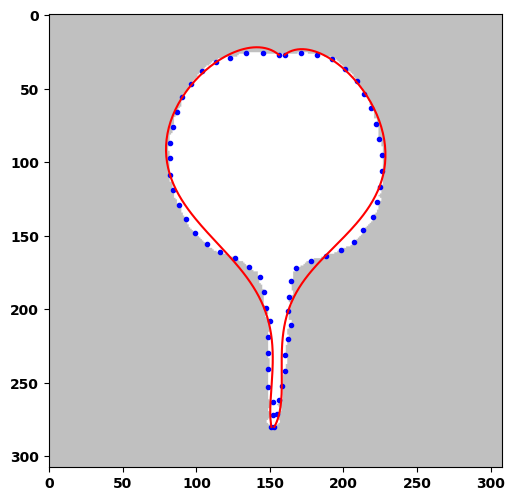

In [5]:
%%time
img = imgs[4]
conLeft,conRight = rd.getCntPairWithImg(img,dtopdr=1,dbtmdr=1)
# 先にもとめた左右の輪郭線からそれぞれ等間隔で32個ずつ標本点を取ってくる
cntL = rd.getSamples(conLeft,N=32)
cntR = rd.getSamples(conRight,N=32)
# ベジエ曲線の近似次数（N)とサンプルをセットしてベジエ曲線のインスタンスを作成
bezL = rd.BezierCurve(N=5,samples=cntL)
bezR = rd.BezierCurve(N=5,samples=cntR)
# rd.BezierCurve.toggledebugmode(set=True,debug=True)
# 高速あてはめの実行
cpsL0,fL0 = bezL.fit0()
cpsR0,fR0 = bezR.fit0()
# 結果の描画
rd.drawBez(img,stt=0.00,end=1.0,bezL=fL0,bezR=fR0,cntL=cntL,cntR=cntR)

## 得られたベジエ曲線の定義式

In [6]:
fL0,fR0

(Matrix([
 [151.0*t**5 + 141.077170617652*t**4*(5 - 5*t) + 2230.24445486295*t**3*(1 - t)**2 - 561.136579753566*t**2*(1 - t)**3 + 518.397324471786*t*(1 - t)**4 + 156.0*(1 - t)**5],
 [ 280.0*t**5 + 225.822792734381*t**4*(5 - 5*t) + 1110.01054420682*t**3*(1 - t)**2 + 1994.43268497734*t**2*(1 - t)**3 - 82.8789168857748*t*(1 - t)**4 + 27.0*(1 - t)**5]]),
 Matrix([
 [153.0*t**5 + 181.322744348827*t**4*(5 - 5*t) + 717.428611740801*t**3*(1 - t)**2 + 3582.68327000528*t**2*(1 - t)**3 + 1052.90061660161*t*(1 - t)**4 + 160.0*(1 - t)**5],
 [  280.0*t**5 + 229.010964364624*t**4*(5 - 5*t) + 1022.53182626091*t**3*(1 - t)**2 + 2243.6418150819*t**2*(1 - t)**3 - 60.0818433577205*t*(1 - t)**4 + 27.0*(1 - t)**5]]))

この式は sympy 形式で表現されており、次のような方法でパラメータ t に値を代入することができます。

In [7]:
fL0.subs('t',0.5)  # fL の t に 0.5 を代入　（左輪郭の中間点の座標） 

Matrix([
[99.9965953959196],
[139.302446124072]])

sympy は数式処理ライブラリですので、具体値だけでなく、次のように式を代入することも可能です。

In [8]:
a,b = var('a,b')
fL0.subs('t',(a+b)**2).subs(a,3)  # t に a+b を代入し、さらに a に３を代入

Matrix([
[156.0*(1 - (b + 3)**2)**5 + 518.397324471786*(1 - (b + 3)**2)**4*(b + 3)**2 - 561.136579753566*(1 - (b + 3)**2)**3*(b + 3)**4 + 2230.24445486295*(1 - (b + 3)**2)**2*(b + 3)**6 + 141.077170617652*(5 - 5*(b + 3)**2)*(b + 3)**8 + 151.0*(b + 3)**10],
[ 27.0*(1 - (b + 3)**2)**5 - 82.8789168857748*(1 - (b + 3)**2)**4*(b + 3)**2 + 1994.43268497734*(1 - (b + 3)**2)**3*(b + 3)**4 + 1110.01054420682*(1 - (b + 3)**2)**2*(b + 3)**6 + 225.822792734381*(5 - 5*(b + 3)**2)*(b + 3)**8 + 280.0*(b + 3)**10]])

sympy の代入 subs は元の式に影響を与えません

In [9]:
fL0 # 代入前の式のままであることを確認せよ

Matrix([
[151.0*t**5 + 141.077170617652*t**4*(5 - 5*t) + 2230.24445486295*t**3*(1 - t)**2 - 561.136579753566*t**2*(1 - t)**3 + 518.397324471786*t*(1 - t)**4 + 156.0*(1 - t)**5],
[ 280.0*t**5 + 225.822792734381*t**4*(5 - 5*t) + 1110.01054420682*t**3*(1 - t)**2 + 1994.43268497734*t**2*(1 - t)**3 - 82.8789168857748*t*(1 - t)**4 + 27.0*(1 - t)**5]])

## 制御点の位置

In [10]:
cpsL0,cpsR0

([[156.0, 27.0],
  [103.67946489435728, -16.575783377154966],
  [-56.11365797535664, 199.44326849773418],
  [223.0244454862948, 111.00105442068246],
  [141.07717061765197, 225.82279273438112],
  [151.0, 280.0]],
 [[160.0, 27.0],
  [210.58012332032274, -12.016368671544095],
  [358.26832700052773, 224.36418150819048],
  [71.74286117408012, 102.25318262609073],
  [181.3227443488272, 229.0109643646245],
  [153.0, 280.0]])

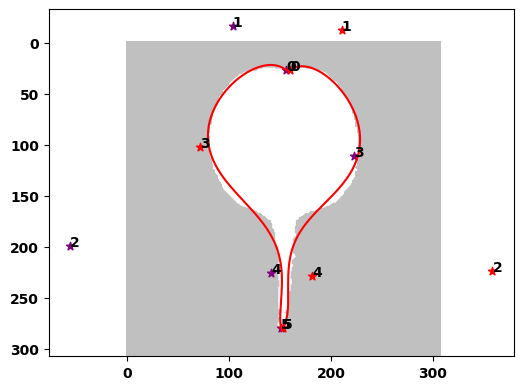

In [11]:
rd.drawBez(img,stt=0.00,end=1.0,bezL=fL0,bezR=fR0,cpl=cpsL0,cpr=cpsR0)

# Eager フィッティング fit1()の実行例
　４次近似  not openmode ( 端点固定 ）

AsymptoticPriority :  distance
dCount    :  3
debugmode :  False
openmode  :  False
wandb  :  None
convg_coe : 1e-05
swing_penalty : 0.0
smoothness_coe : 0.0

....................................................................................................
.........................E

...............................................................................E

Wall time: 57.2 s


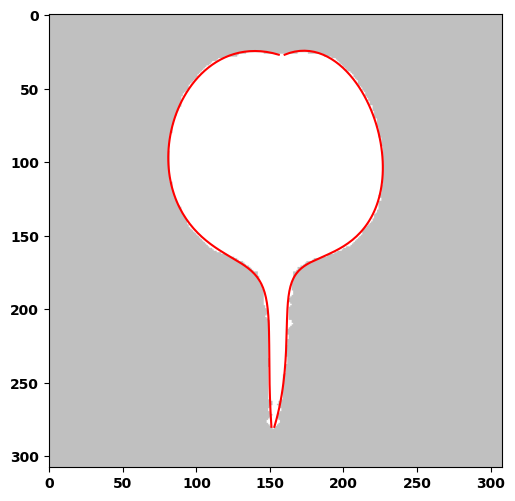

In [12]:
%%time
rd.BezierCurve.setParameters(openmode=False)
bezL = rd.BezierCurve(N=5,samples=cntL)
bezR = rd.BezierCurve(N=5,samples=cntR)
# rd.BezierCurve.toggledebugmode(set=True,debug=True)
# 先にもとめた左右の輪郭線からそれぞれ等間隔で32個ずつ標本点を取ってくる
# cntL = rd.getSamples(conLeft,N=32)
# cntR = rd.getSamples(conRight,N=32)
# ベジエ曲線の近似次数（N)とサンプルをセットしてベジエ曲線のインスタンスを作成
# bezLN = rd.BezierCurve(N=4,samples=cntL)
# bezRN = rd.BezierCurve(N=4,samples=cntR)
# ここまでは先と同じなので2度実行する必要がない
# Eagerあてはめ
rd.BezierCurve.AsymptoticPriority = 'distance'
cpsL1,fL1 = bezL.fit1()
cpsR1,fR1 = bezR.fit1()
# 結果の描画
rd.drawBez(img,stt=0.0,end=1.0,bezL=fL1,bezR=fR1)

# temsolflow版　Eager フィッティング fit1T()の実行例

AsymptoticPriority :  distance
dCount    :  3
debugmode :  False
openmode  :  False
wandb  :  None
convg_coe : 1e-05
swing_penalty : 0.0
smoothness_coe : 0.0

..................................................
.................................................E

Wall time: 17 s


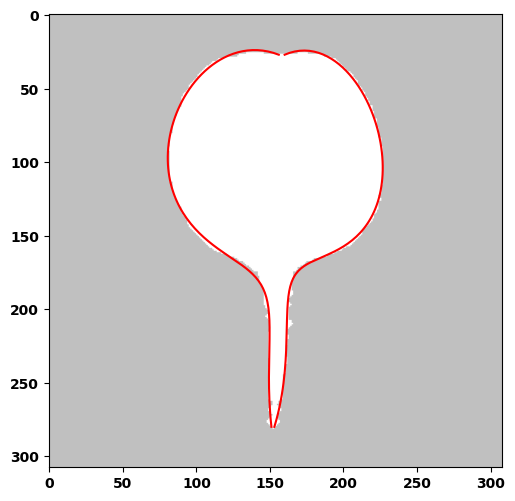

In [13]:
%%time
rd.BezierCurve.setParameters(openmode=False)
#rd.BezierCurve.toggledebugmode(set=True,debug=True)
# 先にもとめた左右の輪郭線からそれぞれ等間隔で32個ずつ標本点を取ってくる
# cntL = rd.getSamples(conLeft,N=32)
# cntR = rd.getSamples(conRight,N=32)
# ベジエ曲線の近似次数（N)とサンプルをセットしてベジエ曲線のインスタンスを作成
# bezLN = rd.BezierCurve(N=4,samples=cntL)
# bezRN = rd.BezierCurve(N=4,samples=cntR)
# ここまでは先と同じなので2度実行する必要がない
# Eagerあてはめ
bezLt = rd.BezierCurve(N=5,samples=cntL)
bezRt = rd.BezierCurve(N=5,samples=cntR)
rd.BezierCurve.AsymptoticPriority = 'distance'
cpsL1t,fL1t = bezLt.fit1T(mode=1,maxTry=50)
cpsR1t,fR1t = bezRt.fit1T(mode=1,maxTry=50)
# 結果の描画
rd.drawBez(img,stt=0.0,end=1.0,bezL=fL1t,bezR=fR1t)

## fit0() と fit1() の結果の違い

オレンジが fit0 （高速）、グリーンが fit1() の結果。

In [14]:
[rd.n2c(int(i)) for i in "221456789"]

[(0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
 (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 1.0),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1.0)]

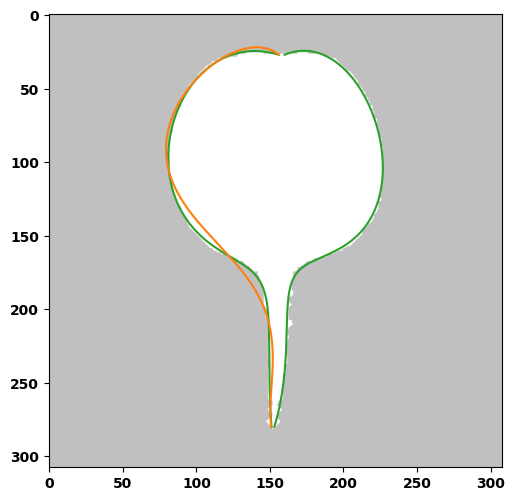

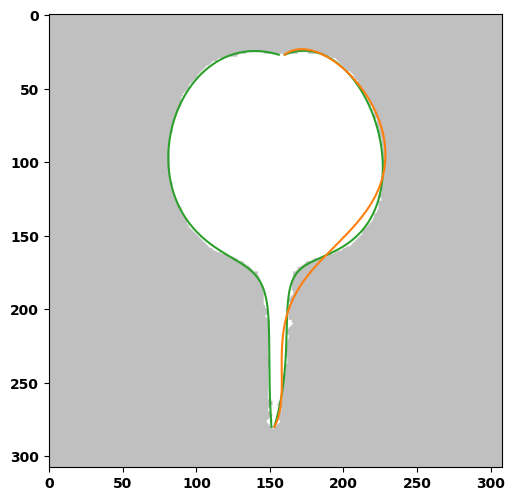

In [15]:
rd.drawBez(img,stt=0.0,end=1.0,bezL=fL1,bezR=fR1,bezC=fL0,ct="221456789")
rd.drawBez(img,stt=0.0,end=1.0,bezL=fL1,bezR=fR1,bezC=fR0,ct="2213456789")

この例は厳密あてはめの方が優れていることが分かりやすい。

これは次数が低いからで、経験的には近似の次数が上がると fit0 と fit1 の差は少なく、大量のデータを処理するなら fit0 でも十分だと思われる。

### 関数式の違い

In [16]:
fL0,fL1,fR0,fR1

(Matrix([
 [151.0*t**5 + 141.077170617652*t**4*(5 - 5*t) + 2230.24445486295*t**3*(1 - t)**2 - 561.136579753566*t**2*(1 - t)**3 + 518.397324471786*t*(1 - t)**4 + 156.0*(1 - t)**5],
 [ 280.0*t**5 + 225.822792734381*t**4*(5 - 5*t) + 1110.01054420682*t**3*(1 - t)**2 + 1994.43268497734*t**2*(1 - t)**3 - 82.8789168857748*t*(1 - t)**4 + 27.0*(1 - t)**5]]),
 Matrix([
 [151.0*t**5 + 141.795473546034*t**4*(5 - 5*t) + 1864.23245835422*t**3*(1 - t)**2 + 268.298248892491*t**2*(1 - t)**3 + 242.418866383502*t*(1 - t)**4 + 156.0*(1 - t)**5],
 [ 280.0*t**5 + 145.837350292614*t**4*(5 - 5*t) + 1417.62749409973*t**3*(1 - t)**2 + 2465.39907926532*t**2*(1 - t)**3 - 28.8646077161006*t*(1 - t)**4 + 27.0*(1 - t)**5]]),
 Matrix([
 [153.0*t**5 + 181.322744348827*t**4*(5 - 5*t) + 717.428611740801*t**3*(1 - t)**2 + 3582.68327000528*t**2*(1 - t)**3 + 1052.90061660161*t*(1 - t)**4 + 160.0*(1 - t)**5],
 [  280.0*t**5 + 229.010964364624*t**4*(5 - 5*t) + 1022.53182626091*t**3*(1 - t)**2 + 2243.6418150819*t**2*(1 - t)**

# Openmode

ベジエ曲線の性質として、曲線は必ず両端の制御点を通る。

そこで、両端の制御点はサンプルの両端であるものとして固定し、両端以外の制御点のみを未知数とすることで、未知数の数を減らしている。

しかし、データとして両端付近はイレギュラーな位置であることが多い。そこで両端を固定せずに未知数としてフィッティングを試みるのが **Openmode** である。

**Openmode** で計算させたい場合は、次のように、 **BezierCurve** のクラス変数 **openmode** の Trueをセットしてから処理を行えばよい。 

In [17]:
rd.BezierCurve.setParameters(openmode=True)

AsymptoticPriority :  distance
dCount    :  3
debugmode :  False
openmode  :  True
wandb  :  None
convg_coe : 1e-05
swing_penalty : 0.0
smoothness_coe : 0.0



....................................................................................................
.............................E

..................................................................................E



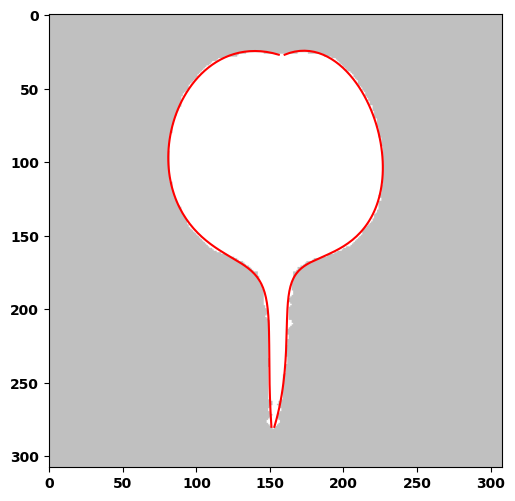

In [18]:
rd.BezierCurve.AsymptoticPriority = 'distance'
cpsL1o,fLo = bezL.fit1()
cpsR1o,fRo = bezR.fit1()
# 結果の描画
rd.drawBez(img,stt=0.0,end=1.0,bezL=fL1,bezR=fR1)

## オープンモードと固定モードの結果比較

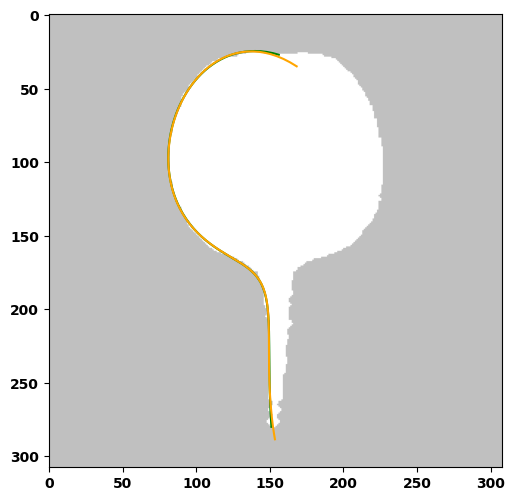

In [19]:
rd.drawBez(img,stt=0.00,end=1.00,bezL=fL1,bezR=fLo,ct=["green","orange"])

シルエットの存在する部分のフィッティング状態にはあまり違いはないように見えるが、オープンモード（オレンジ）の上端点が個体内部に回り込んでいるのがわかる。

*stt=0.0,end=1.0*はどの範囲を描くかの指定である。上下５％カットしてみると、次のようになる。

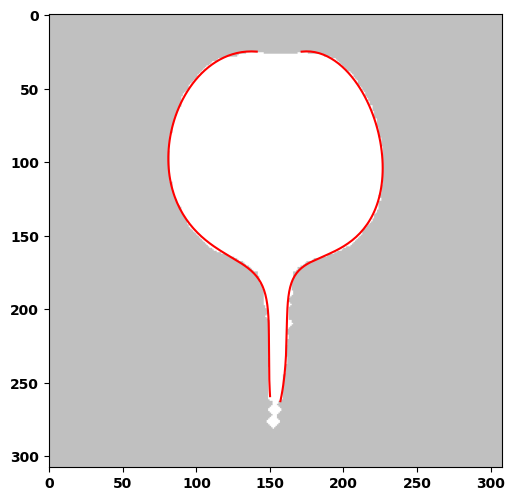

In [20]:
# 両端のカット
rd.drawBez(img,stt=0.05,end=0.95,bezL=fLo,bezR=fRo)

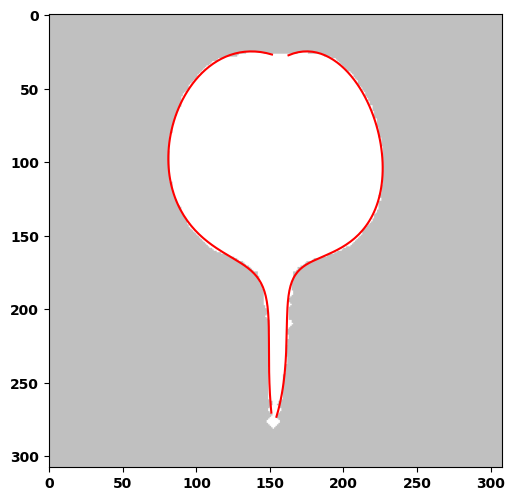

In [21]:
# 両端のカットなし
rd.drawBez(img,stt=0.03,end=0.97,bezL=fLo,bezR=fRo)

# より高次の近似　非openmode  高速　８次

AsymptoticPriority :  distance
dCount    :  3
debugmode :  False
openmode  :  False
wandb  :  None
convg_coe : 1e-05
swing_penalty : 0.0
smoothness_coe : 0.0



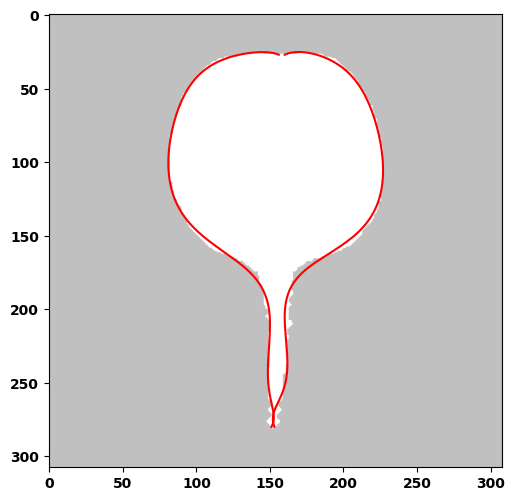

In [22]:
rd.BezierCurve.setParameters(openmode=False)
bezL8 = rd.BezierCurve(N=8,samples=cntL)
bezR8 = rd.BezierCurve(N=8,samples=cntR)
cpsL8,fL8 = bezL8.fit0()
cpsR8,fR8 = bezR8.fit0()
rd.drawBez(img,stt=0.00,end=1.00,bezL=fL8,bezR=fR8)

次数が高いと高速あてはめでも結構きれいに近似できることがわかる。

# より高次の近似　非openmode 厳密　８次

...E

..............E



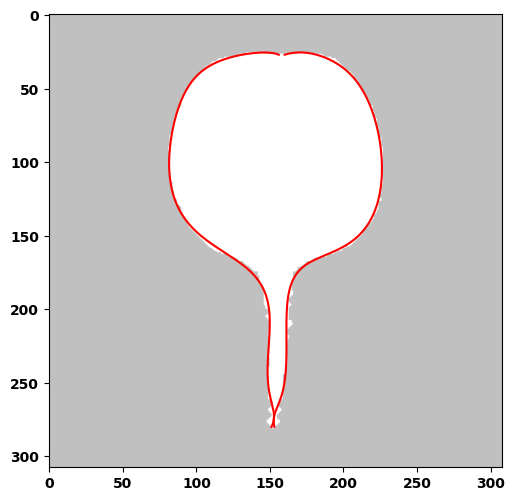

In [23]:
cpsL81,fL81 = bezL8.fit1()
cpsR81,fR81 = bezR8.fit1()
rd.drawBez(img,stt=0.0,end=1.0,bezL=fL81,bezR=fR81)

## 非 openmode 厳密　８次 

AsymptoticPriority :  distance
dCount    :  3
debugmode :  False
openmode  :  False
wandb  :  None
convg_coe : 1e-05
swing_penalty : 0.0
smoothness_coe : 0.0

...E

..............E

Wall time: 10.2 s


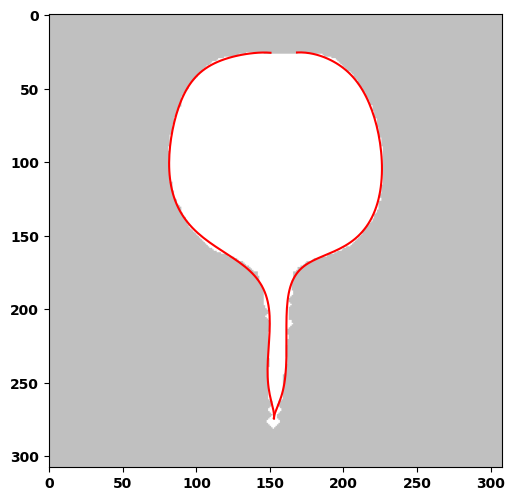

In [24]:
%%time
rd.BezierCurve.setParameters(openmode=False)
cpsL8,fL8 = bezL8.fit1()
cpsR8,fR8 = bezR8.fit1()
rd.drawBez(img,stt=0.02,end=0.98,bezL=fL8,bezR=fR8);

AsymptoticPriority :  distance
dCount    :  3
debugmode :  False
openmode  :  False
wandb  :  None
convg_coe : 1e-05
swing_penalty : 0.0
smoothness_coe : 0.0

....E

...........E

Wall time: 9.28 s


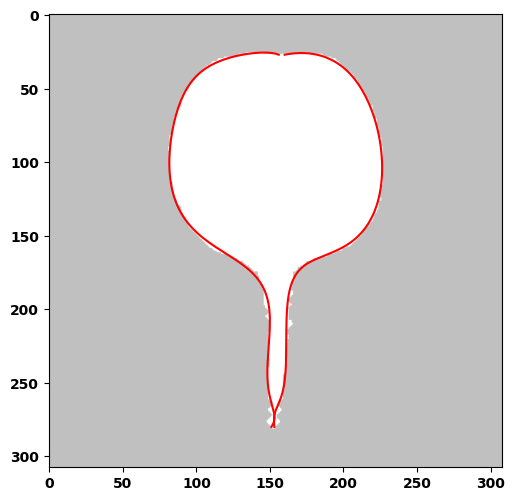

In [25]:
%%time
rd.BezierCurve.setParameters(openmode=False)
#rd.BezierCurve.toggledebugmode(set=True,debug=True)
bezL8 = rd.BezierCurve(N=8,samples=cntL)
bezR8 = rd.BezierCurve(N=8,samples=cntR)
cpsL8T,fL8T = bezL8.fit1T()
cpsR8T,fR8T = bezR8.fit1T()
rd.drawBez(img,stt=0.0,end=1.0,bezL=fL8T,bezR=fR8T);

描き分け

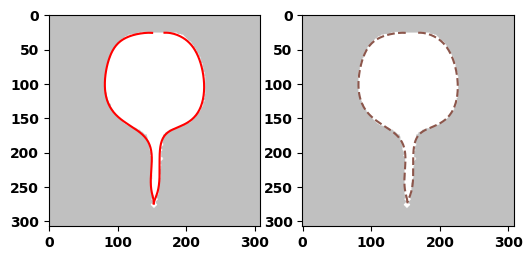

In [26]:
rd.drawBez(img,stt=0.02,end=0.98,bezL=fL8,bezR=fR8,layout=121)
rd.drawBez(img,figsize=None,ct='5550',stt=0.02,end=0.98,bezL=fL8,bezR=fR8,layout=122,linestyle='dashed')

In [2]:
def Demo(imgnum,samples=32,N=5,Amode=0,controlPoints=False):
    # 画像の左右の輪郭線を抽出　（S5参照）
    img = imgs[imgnum]
    conLeft,conRight = rd.getCntPairWithImg(img)
    print("輪郭線の画素数は、左 {}  右{}".format(len(conLeft),len(conRight)))
    Left = rd.getSamples(conLeft,N=samples,mode='Equidistant')
    Right = rd.getSamples(conRight,N=samples,mode='Equidistant')
    # 先にもとめた左右の輪郭線からそれぞれ等間隔で32個ずつ標本点を取ってくる
    # ベジエ曲線の近似次数（N)とサンプルをセットしてベジエ曲線のインスタンスを作成
    bezL = rd.BezierCurve(N=N,samples=Left)
    bezR = rd.BezierCurve(N=N,samples=Right)
    if Amode == 0:
        # 高速あてはめの実行
        cpsL,fL = bezL.fit0()
        cpsR,fR = bezR.fit0()
    else:
        cpsL,fL = bezL.fit1T()
        cpsR,fR = bezR.fit1T()
    # 結果の描画
    if controlPoints:
        rd.drawBez(img,stt=0.00,end=1.0,bezL=fL,bezR=fR,cntL=Left,cntR=Right,cpl=cpsL,cpr=cpsR)
    else:
        rd.drawBez(img,stt=0.00,end=1.0,bezL=fL,bezR=fR,cntL=Left,cntR=Right)

# fit1 のテスト

輪郭線の画素数は、左 297  右299
Wall time: 472 ms


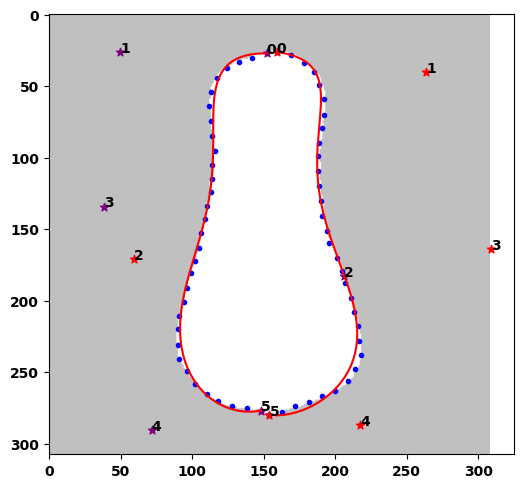

In [28]:
%%time
Demo(0,controlPoints=True)

輪郭線の画素数は、左 323  右323


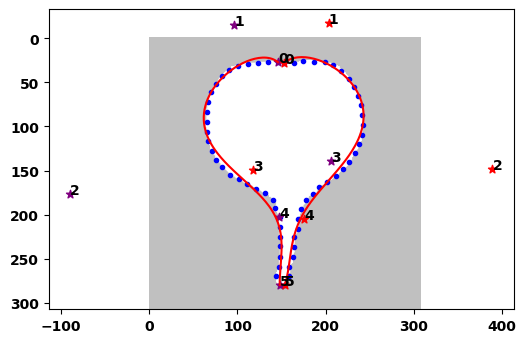

In [29]:
Demo(1,controlPoints=True)

輪郭線の画素数は、左 265  右252


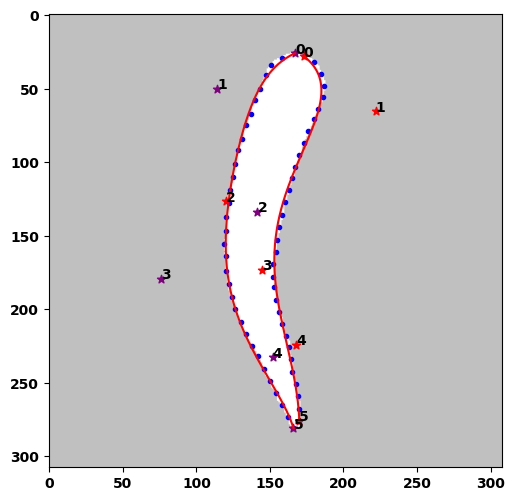

In [30]:
Demo(2,controlPoints=True)

輪郭線の画素数は、左 264  右261


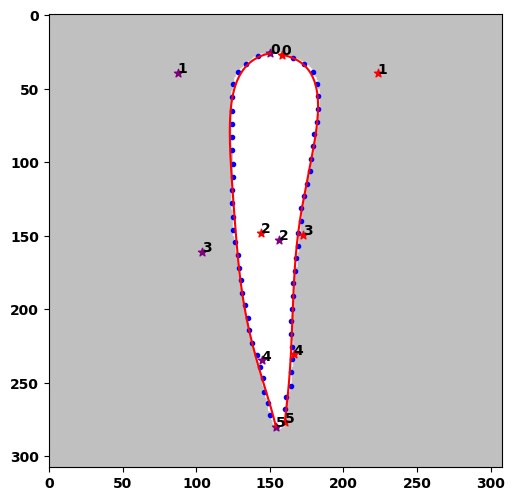

In [31]:
Demo(3,controlPoints=True)

輪郭線の画素数は、左 308  右305


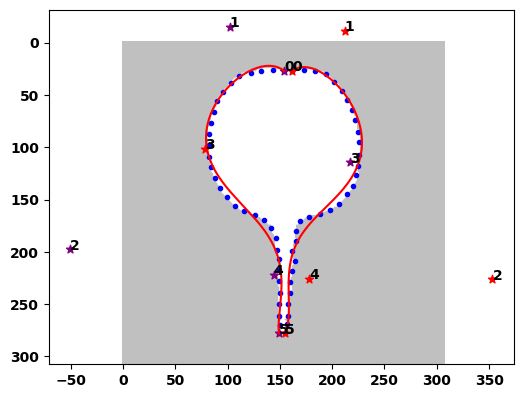

In [32]:
Demo(4,controlPoints=True)

# 8次ベジエ近似

輪郭線の画素数は、左 308  右305


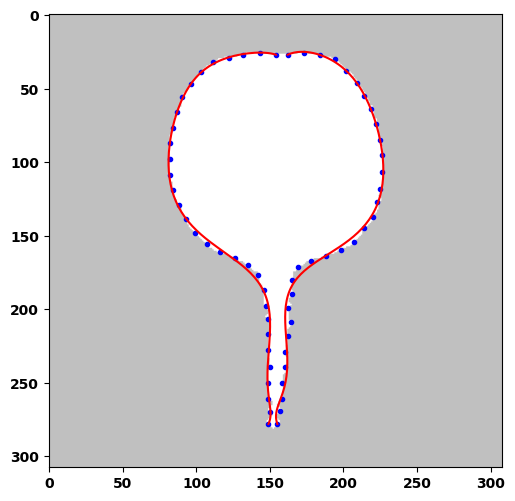

In [33]:
Demo(4,N=8)

輪郭線の画素数は、左 281  右283


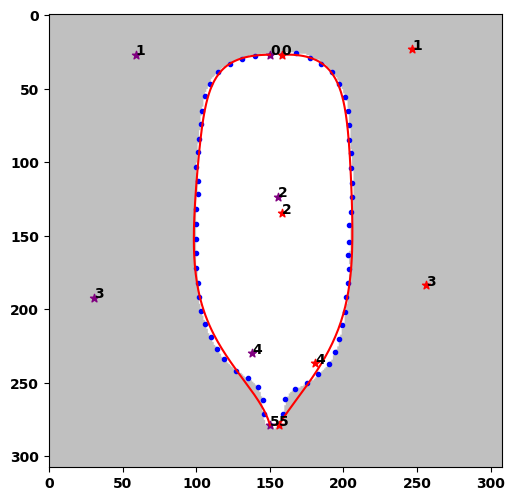

In [34]:
Demo(5,controlPoints=True) #４次

輪郭線の画素数は、左 299  右316


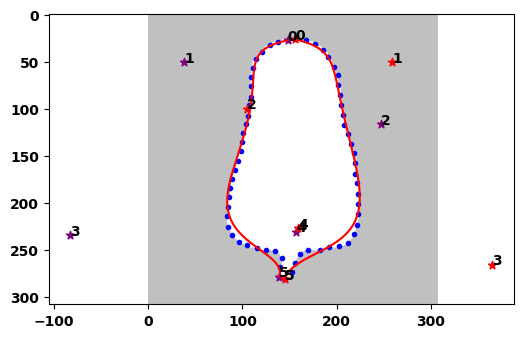

In [35]:
Demo(6,controlPoints=True) #４次

この個体は５次ベジエの高速あてはめモードではいまいちフィッティングしない。次数を上げてやればきれいにフィッティングできる。

輪郭線の画素数は、左 299  右316


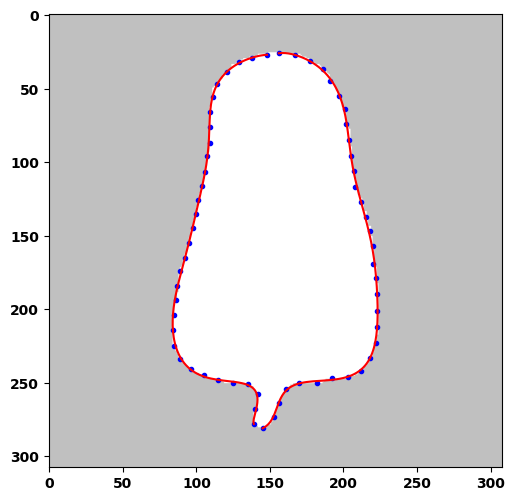

In [36]:
Demo(6,N=12) #12次

輪郭線の画素数は、左 262  右258


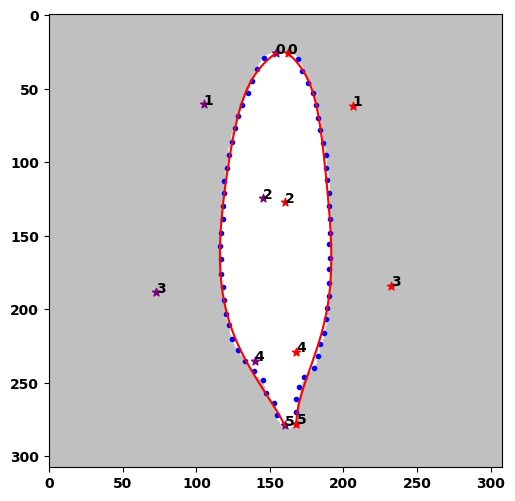

In [37]:
Demo(7,controlPoints=True) # 4次

輪郭線の画素数は、左 263  右260


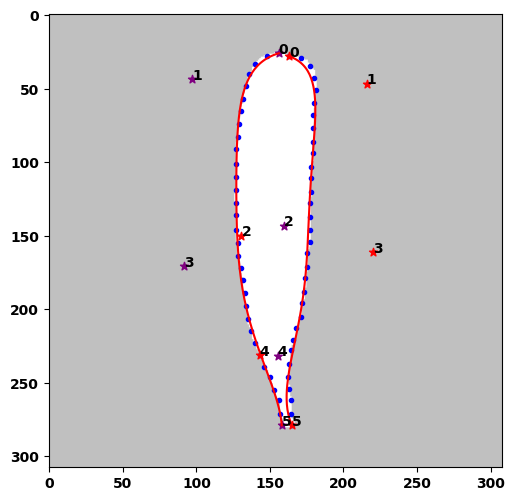

In [38]:
Demo(8,controlPoints=True) # 4次

# Eagerフィッティング (tensorflow版)

先に、ダルマ型のフィッティングで１２次を使ったが、Eagerフィッティング (fit1, fit1T) を使えば、低次でもかなりいい線までフィッティングできる。

# ５次 Eager

輪郭線の画素数は、左 299  右316
..................................E

....................................................................................................
.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^P

Wall time: 1min 8s


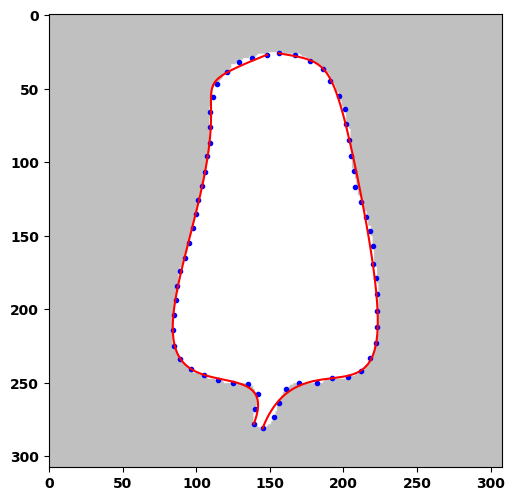

In [39]:
%%time
Demo(6,Amode=1,N=5)

# ６次 Eager

輪郭線の画素数は、左 299  右316
.......E

....................................................................................................
............................................................................................E

Wall time: 45.2 s


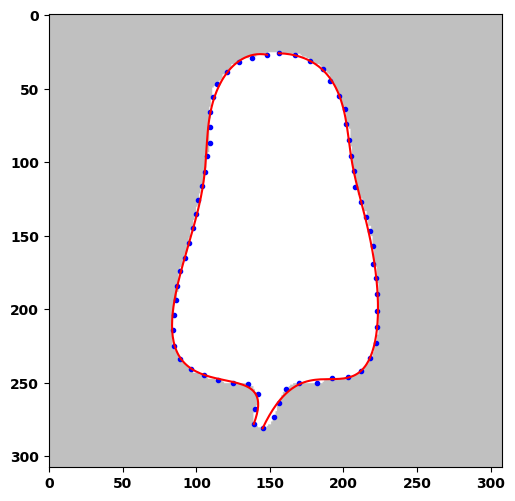

In [40]:
%%time
Demo(6,Amode=1,N=6)

# fit2() 段階的フィッティング

次数を大きく取ると、当てはめは正確になるが、同程度の誤差ならば、なるべく小さい次数で近似したい。

どれくらいの次数が適当なのかは、形状の複雑度を見ればある程度予測できるが、それを自動で行ってくれるのが fit2() である。

停止条件はサンプル点全体の当てはめ誤差の平均値であるが、デフォルトは 0.5、つまり半ピクセルに設定している。

AsymptoticPriority :  distance
dCount    :  3
debugmode :  False
openmode  :  False
wandb  :  None
convg_coe : 1e-05
swing_penalty : 0.0
smoothness_coe : 0.0

3............................................^..^^.^.^.^.^^..^.^.^^^.^.^^^^^.^^^^^.^^^^^^^^^^^^^.^^^^
^^^^^^^^^.^^^.^.^^^^^.^^^^^^^^^^^^^^^^^.^^^^^^^^^^^.^^^^^^^^^^^.^^^^^^^^^^^.^^^^^^^^^^^.^^^^^^^^^^^.
^^^^^^^^^^^.^^^^^^^^^^^.^^^^^^^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^P

4..................
CP 5.0, steps:17, etime: 3.71875 err: 4.4906838718
.........
CP 2.0, steps:26, etime: 5.65625 err: 1.9180984426
..............
CP 1.0, steps:40, etime: 8.46875 err: 0.9884175012
.....................................................E

0.74928336568311153.....................................................................^.....^.....^^^....^^.^...^.^.^
.^.^^^.^...^^^.^^^^^...^^^.^^^^^...^^^^^^^.^^^^^^^^^^.^^^^^^^^^^^^^^^.^^^^^^^^^^^.^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^

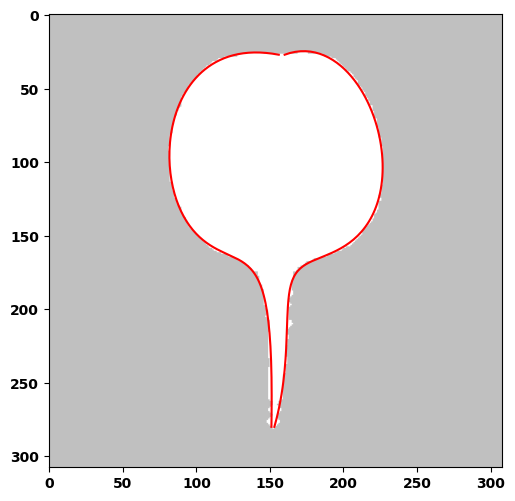

In [91]:
%%time
rd.BezierCurve.setParameters(openmode=False)
img = imgs[4]
conLeft,conRight = rd.getCntPairWithImg(img,dtopdr=1,dbtmdr=1)
# 先にもとめた左右の輪郭線からそれぞれ等間隔で32個ずつ標本点を取ってくる
cntL = rd.getSamples(conLeft,N=32)
cntR = rd.getSamples(conRight,N=32)
# ベジエ曲線の近似次数（N)とサンプルをセットしてベジエ曲線のインスタンスを作成
bezL = rd.BezierCurve(N=5,samples=cntL)
bezR = rd.BezierCurve(N=5,samples=cntR)
# rd.BezierCurve.toggledebugmode(set=True,debug=True) # デバッグモードオン
# 段階的あてはめ
rd.BezierCurve.AsymptoticPriority = 'distance'
NL, resultsL = bezL.fit2(Nfrom=3,Nto=12,cont = [],withErr=True)
NR, resultsR = bezR.fit2(Nfrom=3,Nto=12,cont = [],withErr=True)
# 結果の描画
_,fL2,_ = resultsL[str(NL)]
_,fR2,_ = resultsR[str(NR)]
rd.drawBez(img,stt=0.0,end=1.0,bezL=fL2,bezR=fR2)
print("左は{}次、右は{}次ベジエで近似".format(NL,NR))

# 段階的フィッティング Tensorflow版

AsymptoticPriority :  distance
dCount    :  3
debugmode :  False
openmode  :  False
wandb  :  None
convg_coe : 1e-05
swing_penalty : 0.0
smoothness_coe : 0.0

3...^....^^..........................................C

4............
CP 5.0, steps:11, etime: 1.70312 err: 4.9827333137
....
CP 2.0, steps:15, etime: 2.10938 err: 1.7918549400
...
CP 1.0, steps:18, etime: 2.42188 err: 0.9057862518
..E

0.68334854203545053...^^^...^.............................................C

4................
CP 5.0, steps:15, etime: 2.25000 err: 4.6780421892
..........................^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^P

5.........
CP 5.0, steps:8, etime: 2.14062 err: 4.8829960453
...........
CP 2.0, steps:19, etime: 3.84375 err: 1.9989568607
..........
CP 1.0, steps:29, etime: 5.37500 err: 0.9520379397
....E

0.7415197536025713左は4次、右は5次ベジエで近似
Wall time: 36 s


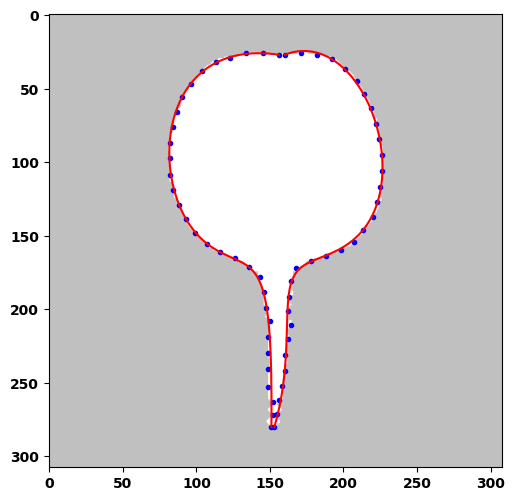

In [2]:
%%time
rd.BezierCurve.setParameters(openmode=False)
img = imgs[4]
conLeft,conRight = rd.getCntPairWithImg(img,dtopdr=1,dbtmdr=1)
# 先にもとめた左右の輪郭線からそれぞれ等間隔で32個ずつ標本点を取ってくる
cntL = rd.getSamples(conLeft,N=32)
cntR = rd.getSamples(conRight,N=32)
# ベジエ曲線の近似次数（N)とサンプルをセットしてベジエ曲線のインスタンスを作成
bezL = rd.BezierCurve(N=5,samples=cntL)
bezR = rd.BezierCurve(N=5,samples=cntR)
# rd.BezierCurve.toggledebugmode(set=True,debug=True) # デバッグモードオン
# 段階的あてはめ
NL, resultsL= bezL.fit2(Nfrom=3,cont = cntL,mode=1,Nto=10,lr=0.005,maxTry=300,withErr=True)
NR, resultsR = bezR.fit2(Nfrom=3,cont = conRight,mode=1,Nto=10,lr=0.005,maxTry=300,withErr=True)
# 結果の描画
_,fL2,err= resultsL[str(NL)]
_,fR2,_ = resultsR[str(NR)]
rd.drawBez(img,stt=0.0,end=1.0,bezL=fL2,bezR=fR2,cntL=cntL,cntR=cntR)
print("左は{}次、右は{}次ベジエで近似".format(NL,NR))
# rd.isOverFitting(fL2,bezL.ts,cntL)

In [12]:
cts = ["1110","2220","3330","4440","5550","6660","7770","8880","9990","0000"]
list(cts[(5-3)%10])

['3', '3', '3', '0']

# 重畳描画できるようにサブクラスを作ってみる

In [11]:
class MyBezierCurve(rd.BezierCurve):
    def __init__(self, N=3, samples = [], prefunc=None):
        super().__init__(N=N, samples = samples, prefunc=prefunc)
    def fit3(self,img,cont = [],Nfrom=3,Nto=12, maxTry = 3000,prefunc = None,errorThres=1.0,withErr=False,tpara=[],withFig=[999]):
        cts = ["1110","2220","3330","4440","5550","6660","7770","8880","9990","0000"]
        Ncurrent = Nfrom - 1
        func = prefunc
        ts = tpara
        err = errorThres + 1
        odds = 0
        while Ncurrent < Nto and  (errorThres < err or len(odds)>0):
            Ncurrent = Ncurrent + 1
            abez = MyBezierCurve(N=Ncurrent,samples=self.samples, prefunc = func)
            print(Ncurrent,end="")
            # 最大 maxTry 回あてはめを繰り返す
            cps,func,err = abez.fit1T(maxTry=maxTry,mode=1,withErr=True,tpara=ts)
            ts = abez.ts
            odds = rd.isOverFitting(func,ts,cont) 
            # 次数を上げてインスタンス生成
            if  999 in withFig or Ncurrent in withFig or Ncurrent == Nto: #  指定されている次数なら描画　ただし最後は常に描画
                rd.drawBez0(img,stt=0.00,end=1.0,bezL=func,ct=list(cts[(Ncurrent-3)%10]),bzlabel=str(Ncurrent)) 
        if withErr:
            return cps,func,Ncurrent,err
        else:
            return cps,func

def Demo(imgnum,samples=32,Nfrom=3,Nto=5,pfL=None,pfR=None,withFig=[999],errorThres=1.0):
    img = imgs[imgnum]
    conLeft,conRight = rd.getCntPairWithImg(img) # 両サイドの輪郭を得る
    Left = rd.getSamples(conLeft,N=samples,mode='Equidistant') # 左輪郭のサンプリング
    Right = rd.getSamples(conRight,N=samples,mode='Equidistant') # 右輪郭のサンプリング 
    bezL = MyBezierCurve(N=0,samples=Left,prefunc=pfL) # 左のベジエカーブ構造体のインスタンスを生成
    bezR = MyBezierCurve(N=0,samples=Right,prefunc=pfR) # 右のベジエカーブ構造体のインスタンスを生成
    fig = plt.figure(figsize =(6, 6)) 
    cpsL,fL,NL,errorL = bezL.fit3(img=img,cont=conLeft,Nfrom=Nfrom,Nto=Nto,maxTry=10,withErr=True,prefunc=pfL,withFig=withFig,errorThres=errorThres)
    cpsR,fR,NR,errorR = bezR.fit3(img=img,cont=conRight,Nfrom=Nfrom,Nto=Nto,maxTry=10,withErr=True,prefunc=pfR,withFig=withFig,errorThres=errorThres)
    plt.legend()
    return fL,fR,NL,NR

3..........
4..........
5.
CP 5.0, steps:0, etime: 0.90625 err: 3.7327299434
.....
CP 2.0, steps:5, etime: 1.64062 err: 1.8405172599
....
3..........
4..........
5......
CP 5.0, steps:5, etime: 1.73438 err: 4.6885361649
....
Wall time: 10 s


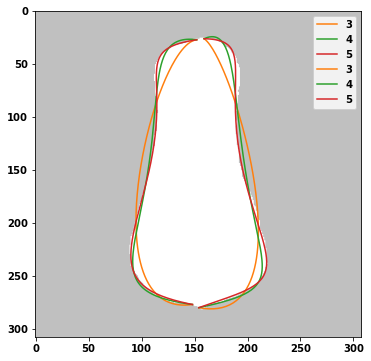

In [3]:
%%time
fL,fR,NL,NR = Demo(0,Nfrom=3,Nto=5)

3..........
4..........
5.
CP 5.0, steps:0, etime: 0.79688 err: 3.7327299434
.....
CP 2.0, steps:5, etime: 1.54688 err: 1.8405172599
....
3..........
4..........
5......
CP 5.0, steps:5, etime: 1.56250 err: 4.6885361649
....
Wall time: 9.3 s


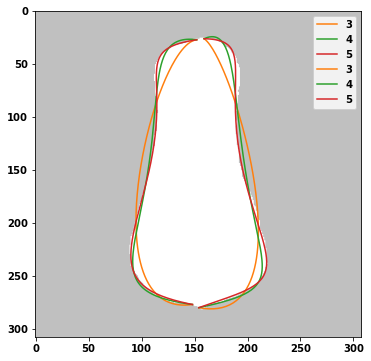

In [4]:
%%time
fLlist,fRlist=[],[]
fL,fR,NL,NR = Demo(0,Nfrom=3,Nto=5)

6.
CP 5.0, steps:0, etime: 1.28125 err: 1.7989168609
.
CP 2.0, steps:1, etime: 1.48438 err: 1.4666356050
..
CP 1.0, steps:3, etime: 1.92188 err: 0.9821092217
..E

6.
CP 5.0, steps:0, etime: 1.25000 err: 0.8243823317
.
CP 2.0, steps:1, etime: 1.45312 err: 0.8071579381
.E

Wall time: 4.37 s


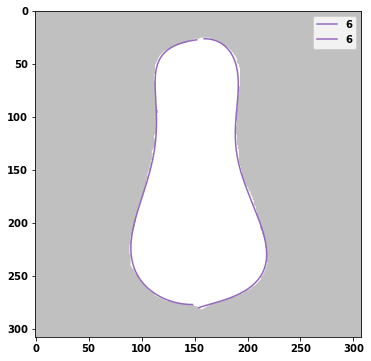

In [5]:
%%time
fL,fR,NL,NR = Demo(0,Nfrom=6,Nto=8,pfL=fL,pfR=fR)
fLlist.append(fL)
fRlist.append(fR)

このダイコンは６〜８次はほとんど違わない。見た感じでは５次でも変わらない気がする。

3..........
4..........
5..........
3..........
4..........
5..........
Wall time: 9.85 s


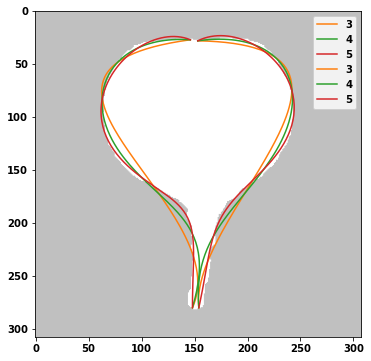

In [10]:
%%time
fL,fR,NL,NR = Demo(1,Nfrom=3,Nto=5)

6.
CP 5.0, steps:0, etime: 1.25000 err: 1.9605584837
.
CP 2.0, steps:1, etime: 1.46875 err: 1.4401698866
..
CP 1.0, steps:3, etime: 1.89062 err: 0.8922927394
.E

6.
CP 5.0, steps:0, etime: 1.23438 err: 2.0376505790
.
CP 2.0, steps:1, etime: 1.45312 err: 1.6358681807
....
CP 1.0, steps:5, etime: 2.29688 err: 0.9773737957
....E

Wall time: 5.74 s


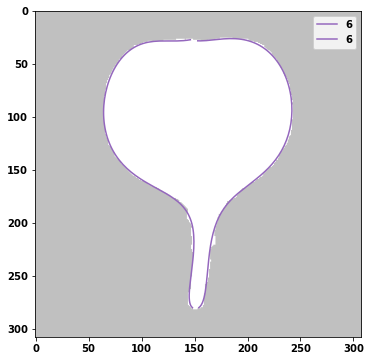

In [6]:
%%time
fL,fR,NL,NR = Demo(1,Nfrom=6,Nto=8,pfL=fL,pfR=fR)
fLlist.append(fL)
fRlist.append(fR)

６次で十分

3....^^....
4........E

5.E

3..........
4..........E

5.E

Wall time: 7.07 s


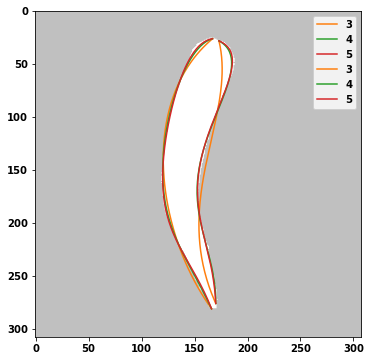

In [12]:
%%time
fL,fR,NL,NR = Demo(2,Nfrom=3,Nto=5)

6.E

6.
CP 5.0, steps:0, etime: 1.25000 err: 0.7591831723
.E

Wall time: 3.16 s


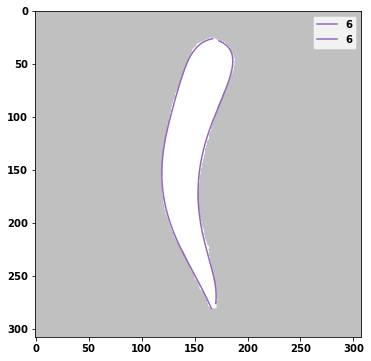

In [7]:
%%time
fL,fR,NL,NR = Demo(2,Nfrom=6,Nto=8,pfL=fL,pfR=fR)
fLlist.append(fL)
fRlist.append(fR)

６次で十分

3..........
4..........
5.E

3..........
4.E

5.E

Wall time: 6.09 s


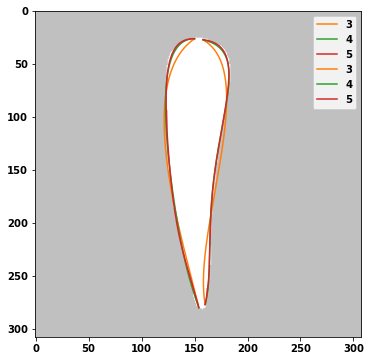

In [14]:
%%time
fL,fR,NL,NR = Demo(3,Nfrom=3,Nto=5)

6.E

6.E

Wall time: 2.82 s


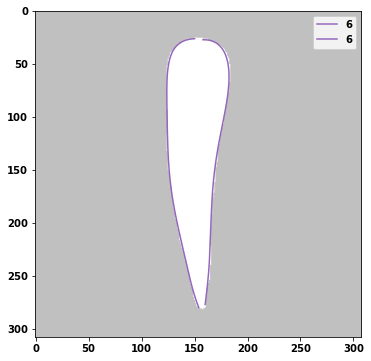

In [8]:
%%time
fL,fR,NL,NR = Demo(3,Nfrom=6,Nto=8,pfL=fL,pfR=fR)
fLlist.append(fL)
fRlist.append(fR)

3..........
4..........
5..........
3..........
4..........
5..........
Wall time: 9.58 s


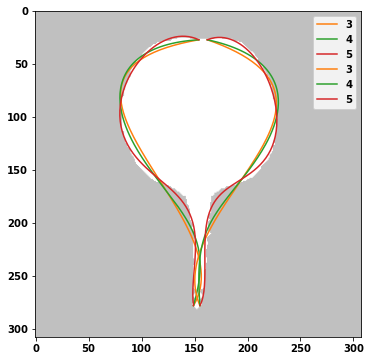

In [17]:
%%time
fL,fR,NL,NR = Demo(4,Nfrom=3,Nto=5)

6.
CP 5.0, steps:0, etime: 1.25000 err: 4.7388142471
.....
CP 2.0, steps:5, etime: 2.31250 err: 1.8918654919
....
CP 1.0, steps:9, etime: 3.15625 err: 0.9401421717

6.....
CP 5.0, steps:4, etime: 2.10938 err: 4.4915413936
.....
7.
CP 5.0, steps:0, etime: 1.68750 err: 1.0730698625
.
CP 2.0, steps:1, etime: 1.96875 err: 0.8318415251
.E

8.E

Wall time: 11.4 s


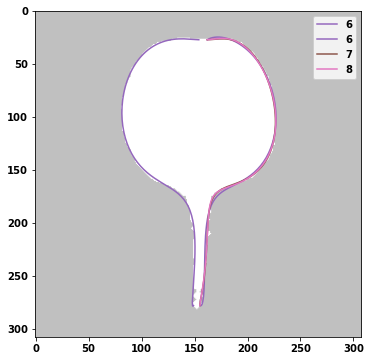

In [9]:
%%time
fL,fR,NL,NR = Demo(4,Nfrom=6,Nto=8,pfL=fL,pfR=fR)
fLlist.append(fL)
fRlist.append(fR)

9...E

10.E

9.......E

10.E

Wall time: 15.8 s


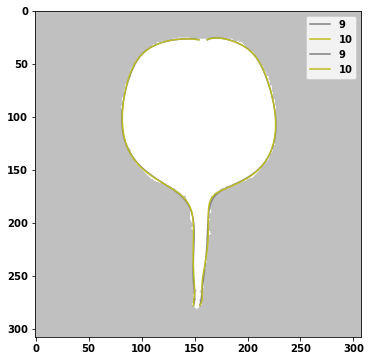

In [19]:
%%time
fL,fR,NL,NR = Demo(4,Nfrom=9,Nto=10,pfL=fL,pfR=fR)

６次以上はあまり差はないように見える。

3..........
4..........
5.........E

3..........
4..........
5..........
Wall time: 9.59 s


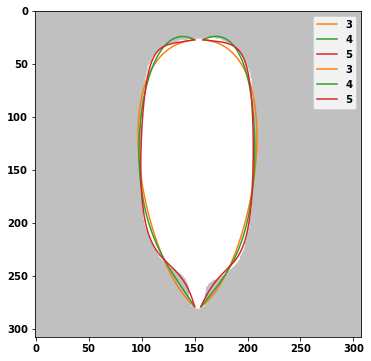

In [20]:
%%time
fL,fR,NL,NR = Demo(5,Nfrom=3,Nto=5)

6...E

7.E

8.E

6......E

7.E

8.E

Wall time: 12.8 s


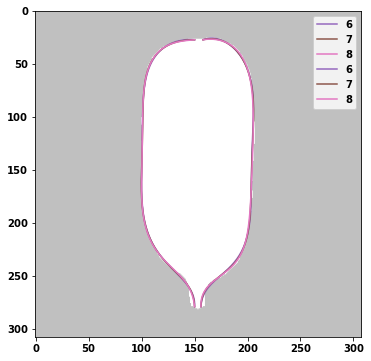

In [21]:
%%time
fL,fR,NL,NR = Demo(5,Nfrom=6,Nto=8,pfL=fL,pfR=fR)

9.E

9.E

Wall time: 5.9 s


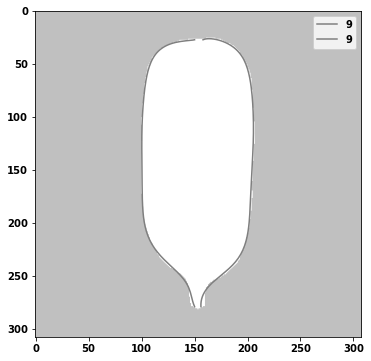

In [10]:
%%time
fL,fR,NL,NR = Demo(5,Nfrom=9,Nto=10,pfL=fL,pfR=fR)
fLlist.append(fL)
fRlist.append(fR)

６次以上はあまり差がない

3..........
4..........
5..........
3..........
4..........
5..........
Wall time: 9.81 s


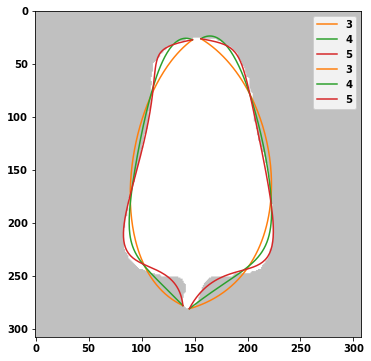

In [23]:
%%time
fL,fR,NL,NR = Demo(6,Nfrom=3,Nto=5)

6.......E

7.E

8.E

6..........
7..........
8..^.....E

Wall time: 19.7 s


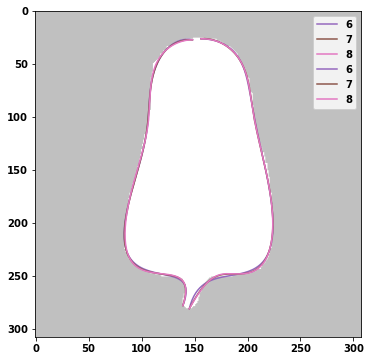

In [24]:
%%time
fL,fR,NL,NR = Demo(6,Nfrom=6,Nto=8,pfL=fL,pfR=fR)

9.E

10.E

9.
CP 5.0, steps:0, etime: 2.73438 err: 0.8091375894
.
CP 2.0, steps:1, etime: 3.20312 err: 0.7674238126
.E

Wall time: 10.1 s


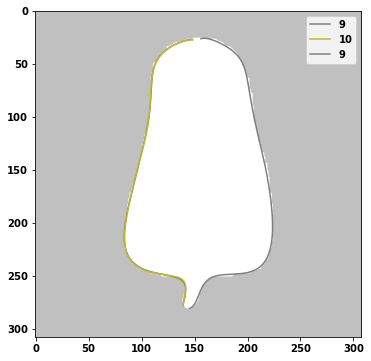

In [11]:
%%time
fL,fR,NL,NR = Demo(6,Nfrom=9,Nto=10,pfL=fL,pfR=fR)
fLlist.append(fL)
fRlist.append(fR)

８次と９次で末端部が大きく変化したが、末端部の切り取り箇所が不適当なのと角ばり部分ができたために必要次数が上がったものであり、そこが除ければもっと低い次数で大丈夫だと思われる。

3..........
4..........
5...E

3..........
4..........
5..........
Wall time: 8.64 s


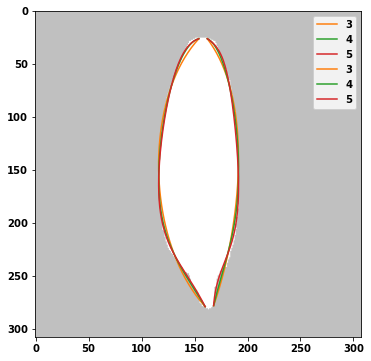

In [26]:
%%time
fL,fR,NL,NR = Demo(7,Nfrom=3,Nto=5)

6.
CP 5.0, steps:0, etime: 1.26562 err: 0.9748559750
^
CP 2.0, steps:1, etime: 1.46875 err: 1.0154641382
.
CP 1.0, steps:2, etime: 1.67188 err: 0.9612039859
.......E

6.
CP 5.0, steps:0, etime: 1.23438 err: 0.8375944460
^
CP 2.0, steps:1, etime: 1.43750 err: 0.8518430074
.E

Wall time: 5.23 s


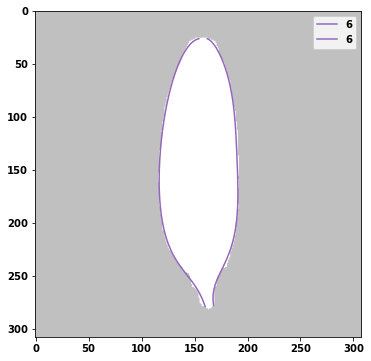

In [12]:
%%time
fL,fR,NL,NR = Demo(7,Nfrom=6,Nto=8,pfL=fL,pfR=fR)
fLlist.append(fL)
fRlist.append(fR)

６次で十分である

3..........
4..........
5.E

3..........
4..........
5.E

Wall time: 6.99 s


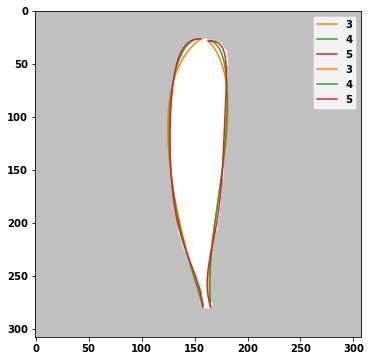

In [28]:
%%time
fL,fR,NL,NR = Demo(8,Nfrom=3,Nto=5)

6.E

6.E

Wall time: 2.81 s


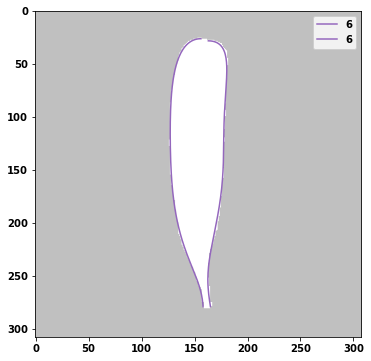

In [13]:
%%time
fL,fR,NL,NR = Demo(8,Nfrom=6,Nto=8,pfL=fL,pfR=fR)
fLlist.append(fL)
fRlist.append(fR)

６次で十分だろう

In [16]:
# 結果の保存
# フォルダ指定
labhome = COLABRDROOT if COLABORATORY else LOCALHOME
import platform
resdir = "/res/windows" if platform.system() == "Windows" else "/res"
rd.storePkl(fLlist,"fLlist.pkl",labhome+resdir) # 左側の近似曲線のリスト
rd.storePkl(fRlist,"fRlist.pkl",labhome+resdir) # 右側の近似曲線のリスト

低い次数では、尻尾の部分の形までフィッティングするのは困難である。しかし、その部分を近似することに意味はないのでかまわないだろう。

自動化の観点でいえば、問題はそういう部分を自動的にカットするのが難しいという点にある。


# 全周ベジエ近似

上端点を完全自動で求めることは、一般的には困難であるが下端は先細りであることが普通なので、自動検出もそう難しくはない。

下端点を起点かつ終点とする全周の点列を1本のベジエ曲線で近似できるかやってみる。

なお、下のプログラムでは、fit2 で cont パラメータをセットしているが、そうすることでオーバフィッティングチェックが入り、エラーが小さくてもオーバフィッティングが生じている場合は繰り返しを続ける。

In [6]:
def check(imgnum,samples=65,Nfrom=3,Nto=15,mode=1,errorThres=1.0):
    img = imgs[imgnum]
    conAll = rd.getCntPairWithImg(img, mode=1) # 全周輪郭を得る
    Samples = rd.getSamples(conAll,N=samples,mode='Equidistant')
    bez = rd.BezierCurve(N=0,samples=Samples) # インスタンス生成
    lastN,results = bez.fit2(Nfrom=Nfrom,Nto=Nto,cont = conAll, mode=1,lr=0.001, lrP=30000, maxTry=3000, pat=300, err_th=errorThres,withErr=True)
    cps,func,err = results[str(lastN)]
    print(rd.isOverFitting(func,bez.ts,conAll))
    rd.drawBez(img,stt=0.0,end=1.0,bezL=func)
    print("{}次でOK".format(lastN))
    return results

def DemoAll2(imgnum,results,withFig=[999]):
    img = imgs[imgnum]
    fig = plt.figure(figsize =(6, 6)) 
    cts = ["1110","2220","3330","4440","5550","6660","7770","8880","9990","0000"]
    plt.figure(figsize=(12,6),dpi=150)
    plt.subplot(151)
    plt.imshow(192+(cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)/4).astype(np.uint8),label="silhouette")
    plt.axis('off')
    linesnum = 0
    for Ncurrent in withFig :
        cps,func,err = results[str(Ncurrent)]
        rd.drawBez(img,figsize=None,layout=int("15"+str(linesnum+2)),stt=0.00,end=1.0,bezL=func,ct="3330",bzlabel=str(Ncurrent),linestyle=0)
        plt.legend(loc=1,prop={"size":6})
        plt.axis('off')
        linesnum +=1

3....................................................................................................
....................................................................................................

4......................................................................................C

5....................................................................................................
....................................................................................................

6..............................................................C

7....................................................................................................
...
CP 5.0, steps:102, etime: 53.26562 err: 4.8841331850
..................................
CP 2.0, steps:136, etime: 69.95312 err: 1.9541646574
..............................E

0.98781331896018937次でOK
Wall time: 3min 17s


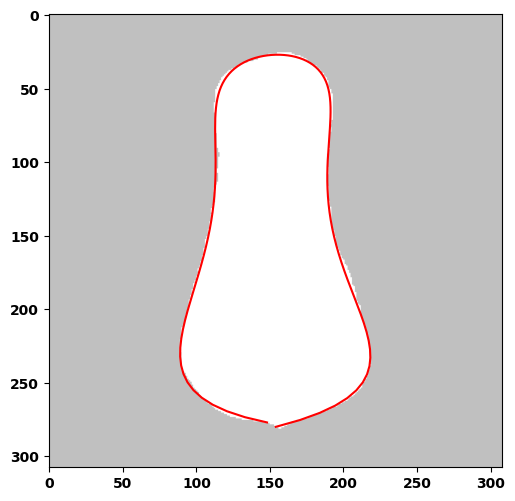

In [18]:
%%time
results = check(0,samples=65,Nfrom=6,Nto=12,errorThres=1.0)

<Figure size 432x432 with 0 Axes>

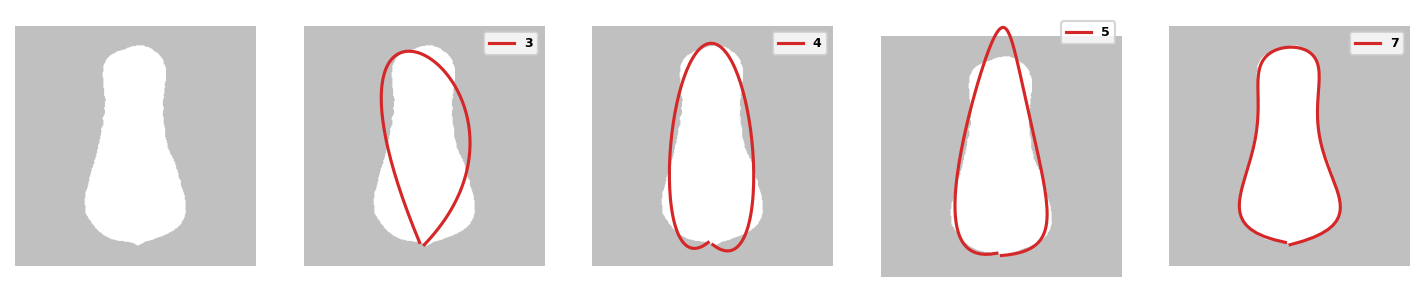

In [23]:
DemoAll2(0,results,withFig=[3,4,5,7])

3................................................................................C

4....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..............................................................................................C

5.......e1e1.e1e1e1.e1e1...........................................................................................
..................................................C

6....................................................................................................
....................................................................................................
..........................................

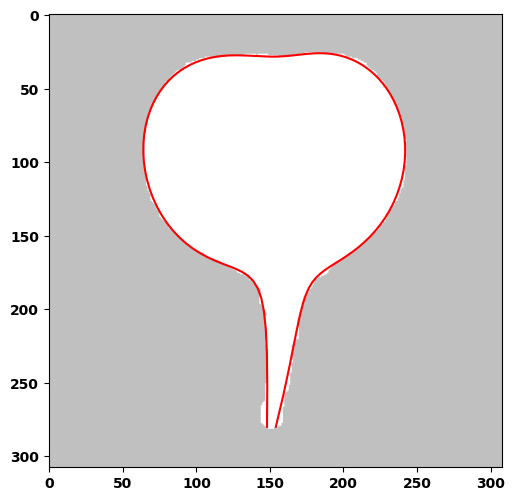

In [24]:
%%time
results1 = check(1,samples=65,Nfrom=3,Nto=15,errorThres=1.0)

<Figure size 432x432 with 0 Axes>

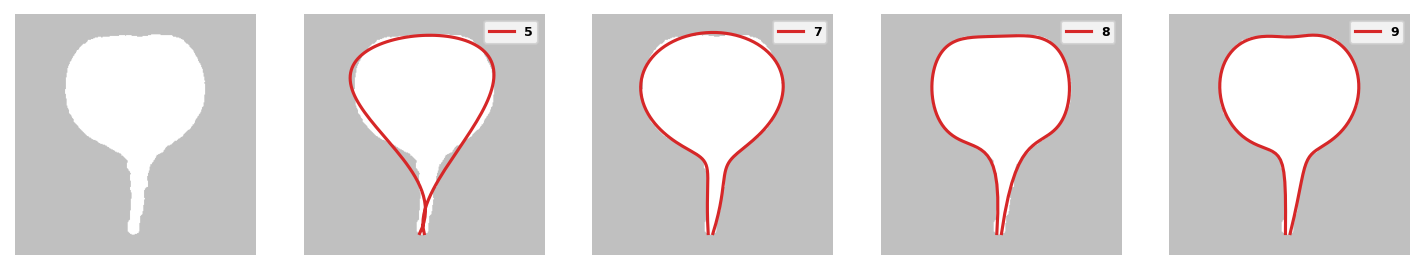

In [25]:
DemoAll2(1,results1,withFig=[5,7,8,9])

3....................................................................................................
....................................................................................................

4....................................................................................................
....................................................................................................

5....................................................................................................
....................................................................................................
......................................................
CP 5.0, steps:253, etime: 66.95312 err: 4.9974562963
..............................................
....................................................................................................
....................................................................................................
................................

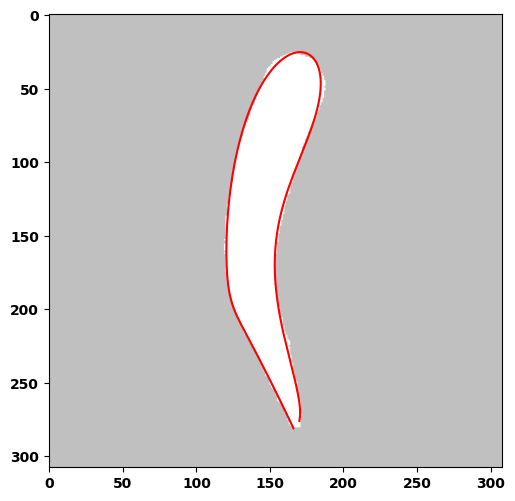

In [26]:
%%time
results2 = check(2,samples=65,Nfrom=5,Nto=12,errorThres=1.0)

<Figure size 432x432 with 0 Axes>

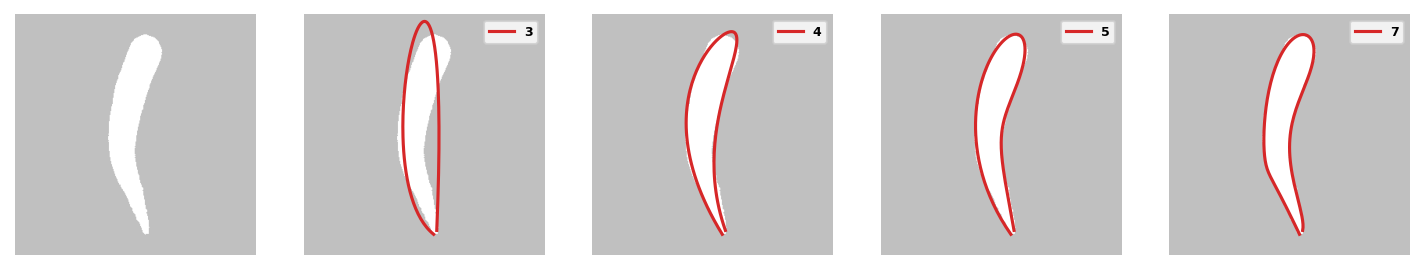

In [27]:
DemoAll2(2,results2,withFig=[3,4,5,7])

3....................................................................................................
....................................................................................................
...........................................................................................C

4....................................................................................................
...........................................
CP 5.0, steps:142, etime: 24.67188 err: 4.9862513462
.........................................................
....................................................................................................
.........................^..............................................^^.^.^^.^^^.^...............
.....................^^^.^..^.......^^^.^............^^^..^.^.^^^^^.^.^..^.^.................^^^^.^.
^.^^^.^^^.^^^^.^^^^.^.^..C

5....................................................................................................
.............

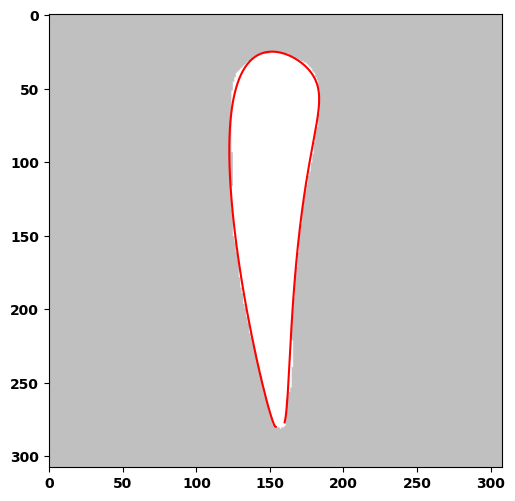

In [3]:
%%time
results3 = check(3,samples=65,Nfrom=3,Nto=7,errorThres=1.0)

<Figure size 432x432 with 0 Axes>

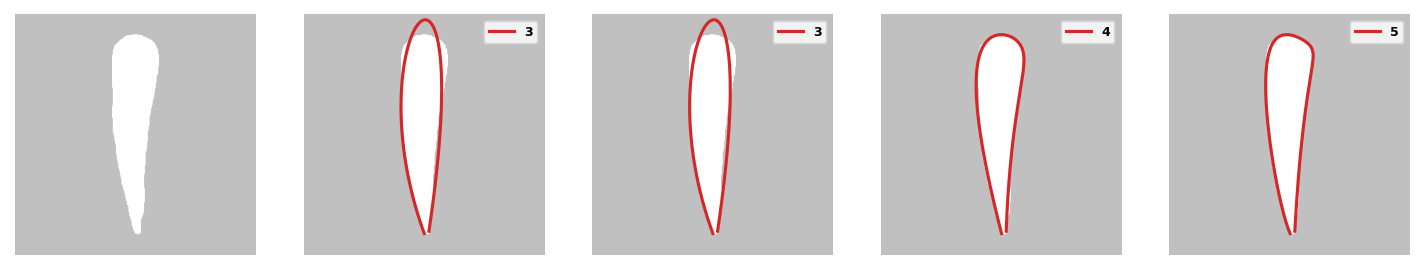

In [4]:
DemoAll2(3,results3,withFig=[3,3,4,5])

3...............................................................................C

4....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
............................................................................C

5....................................................................................................
............................................................................C

6.................................................

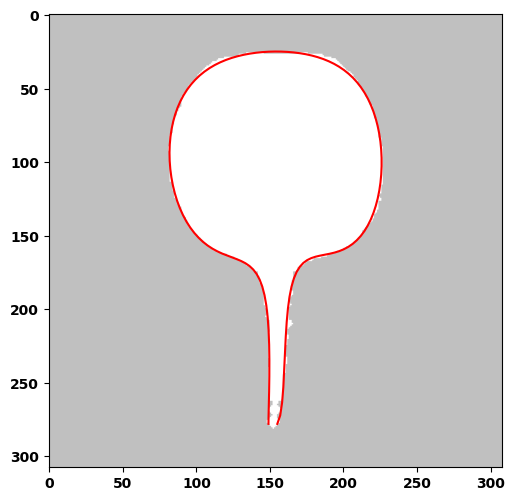

In [5]:
%%time
results4 = check(4,samples=65,Nfrom=3,Nto=15,errorThres=1.0)

<Figure size 432x432 with 0 Axes>

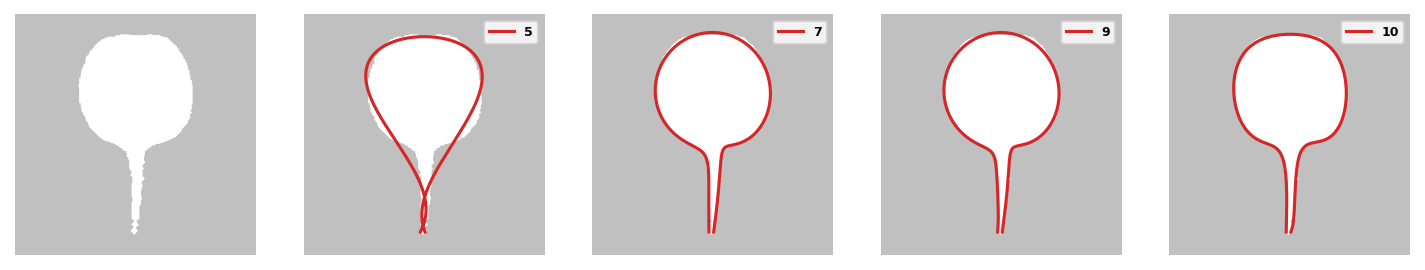

In [6]:
DemoAll2(4,results4,withFig=[5,7,9,10])

3....................................................................................................
.........C

4....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.......................................................................C

5...........^^.......................................................................................
....................................................................................................
....................................................................................................
..

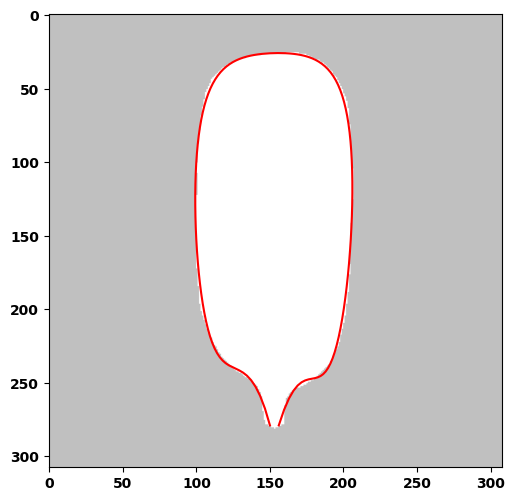

In [7]:
%%time
results5 = check(5,samples=65,Nfrom=3,Nto=15,errorThres=1)

<Figure size 432x432 with 0 Axes>

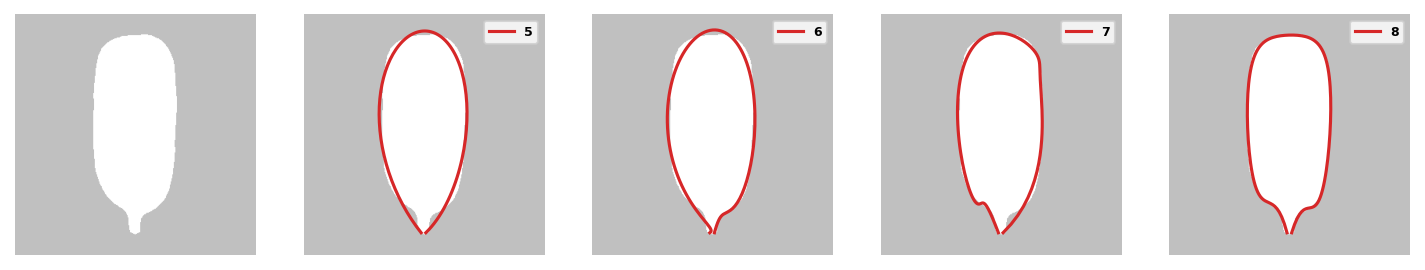

In [8]:
DemoAll2(5,results5,withFig=[5,6,7,8])

3....................................................................................................
............................................................................................C

4......e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1...........................................................
..C

5..e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1...............................................
............................................................................

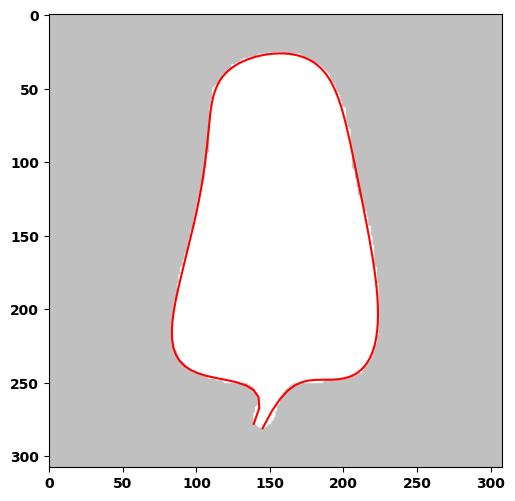

In [9]:
%%time
results6 = check(6,samples=65,Nfrom=3,Nto=15,errorThres=1)

<Figure size 432x432 with 0 Axes>

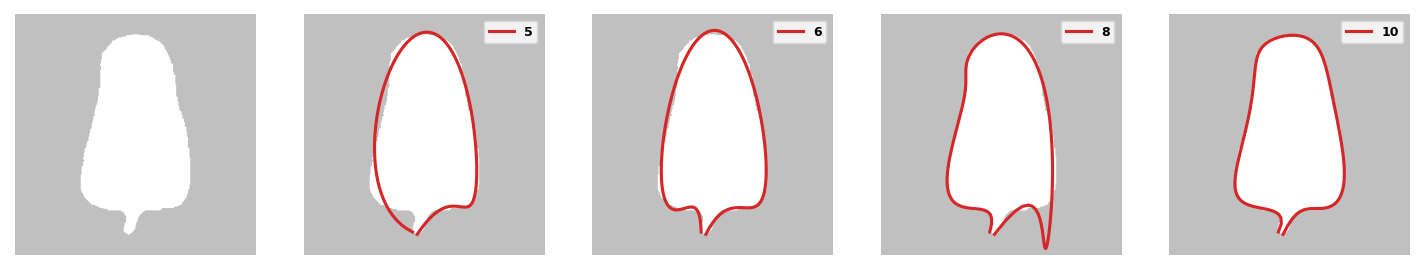

In [11]:
DemoAll2(6,results6,withFig=[5,6,8,10])

3....................................................................................................
....................................................................................................
.....................................................................................C

4.....................................................
CP 5.0, steps:52, etime: 9.62500 err: 4.9722250175
...............................................
....................................................................................................
...............................................................C

5....................................................................................................
.................................................................................................
CP 5.0, steps:196, etime: 51.42188 err: 4.9925951592
...
....................................................................................................
..............................

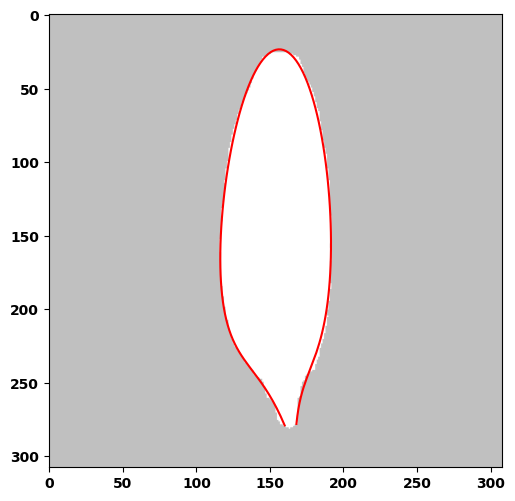

In [12]:
%%time
results7 = check(7,samples=65,Nfrom=3,Nto=15,errorThres=1)

<Figure size 432x432 with 0 Axes>

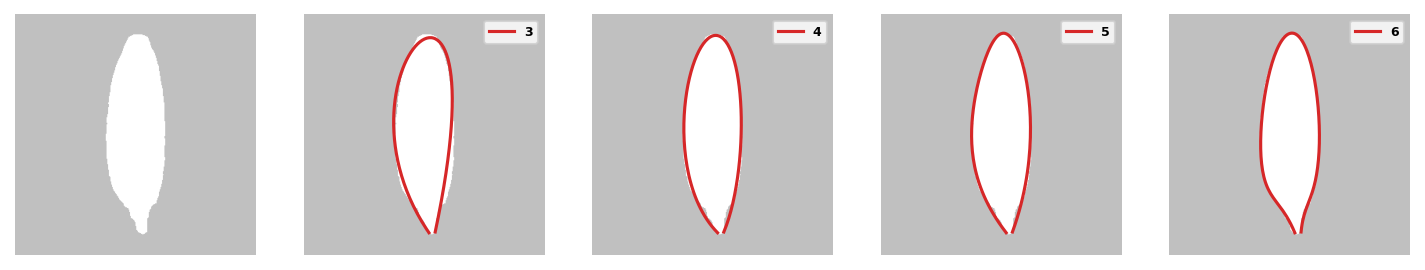

In [13]:
DemoAll2(7,results7,withFig=[3,4,5,6])

3....................................................................................................
....................................................................................................
............................................................................................^.......
.................................C

[32 33]
4....................................................................................................
..................
CP 5.0, steps:117, etime: 20.42188 err: 4.9572807296
..................................................................................
....................................................................................................
....................................................................................................
.........................................................^..........................................
............................................................................................

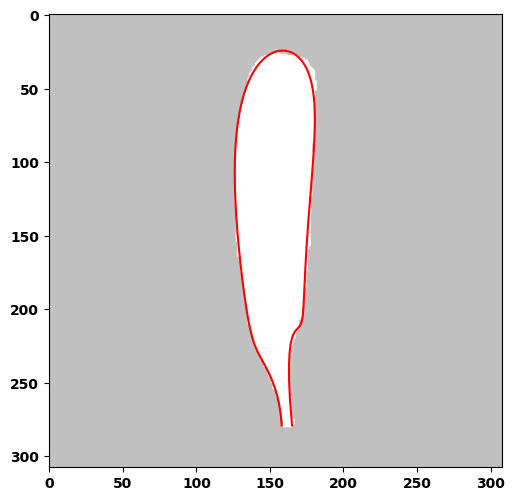

In [7]:
%%time
results8 = check(8,samples=65,Nfrom=3,Nto=15,errorThres=1.)

<Figure size 432x432 with 0 Axes>

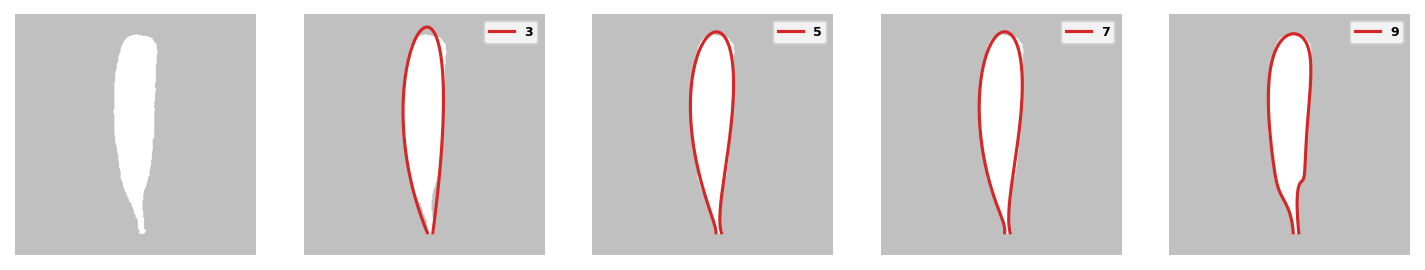

In [8]:
DemoAll2(8,results8,withFig=[3,5,7,9])

In [9]:
def DemoAll(imgnum,samples=64,Nfrom=6,Nto=15,pf=None,draw=[],withFig=[999]):
    img = imgs[imgnum]
    conAll = rd.getCntPairWithImg(img, mode=1)  # 全周輪郭を得る
    print("輪郭線の画素数は、{}".format(len(conAll)))
    Samples = rd.getSamples(conAll,N=samples,mode='Equidistant')
    # ベジエ曲線の近似次数（N)とサンプルをセットしてベジエ曲線のインスタンスを作成
    bez = MyBezierCurve(N=0,samples=Samples,prefunc=pf) # インスタンス生成
    fig = plt.figure(figsize =(6, 6)) 
    cps,fall,N,error = bez.fit3(img=img,Nfrom=Nfrom,Nto=Nto,maxTry=3000,withErr=True,prefunc=pf,withFig=withFig)
    plt.legend()
    print("必要次数は",N)
    return fall,N

輪郭線の画素数は、602
11..
CP 5.0, steps:1, etime: 3.75000 err: 4.1745326792
...........
CP 2.0, steps:12, etime: 11.00000 err: 1.9717642935
..............
CP 1.0, steps:26, etime: 20.12500 err: 0.9797955382
........E

必要次数は 11
Wall time: 25.7 s


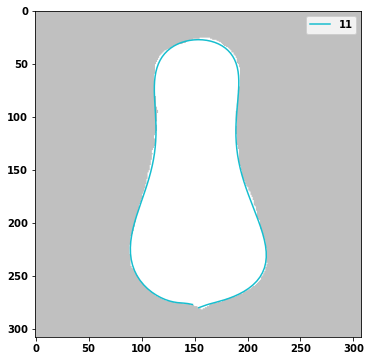

In [12]:
%%time
fall=[]
fl,N = DemoAll(0,samples=31,Nfrom=11,Nto=11,pf=None,withFig=[11])
fall.append(fl)

輪郭線の画素数は、652
11......
CP 5.0, steps:5, etime: 6.42188 err: 4.7488636491
..............................................................................................
.....
CP 2.0, steps:104, etime: 71.59375 err: 1.9925013003
...............................................................................................
..................................................
CP 1.0, steps:249, etime: 167.21875 err: 0.9970896519
..................................................
......E

必要次数は 11
Wall time: 3min 24s


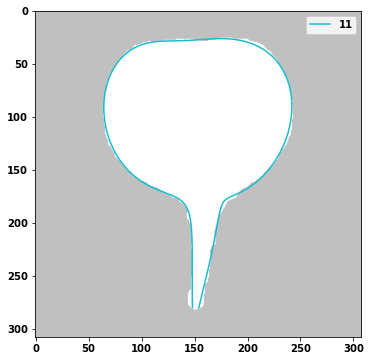

In [13]:
%%time
fl,N = DemoAll(1,samples=31,Nfrom=11,Nto=11,pf=None,withFig=[11])
fall.append(fl)

輪郭線の画素数は、522
11.
CP 5.0, steps:0, etime: 3.10938 err: 4.3924100517
...
CP 2.0, steps:3, etime: 5.09375 err: 1.8327013732
...........
CP 1.0, steps:14, etime: 12.32812 err: 0.9974762598
.........E

必要次数は 11
Wall time: 18.4 s


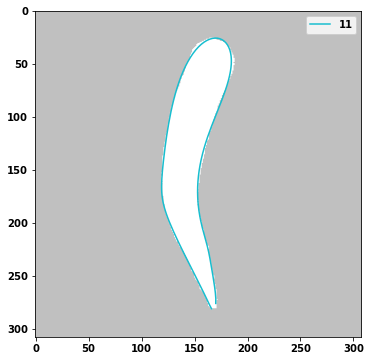

In [14]:
%%time
fl,N = DemoAll(2,samples=31,Nfrom=11,Nto=11,pf=None,withFig=[11])
fall.append(fl)

輪郭線の画素数は、532
11.
CP 5.0, steps:0, etime: 3.10938 err: 2.5567434208
..
CP 2.0, steps:2, etime: 4.40625 err: 1.8225827188
.^.....................
CP 1.0, steps:25, etime: 19.48438 err: 0.9829343249
..............E

必要次数は 11
Wall time: 28.8 s


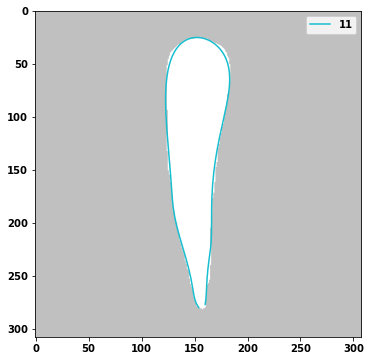

In [15]:
%%time
fl,N = DemoAll(3,samples=31,Nfrom=11,Nto=11,pf=None,withFig=[11])
fall.append(fl)

輪郭線の画素数は、620
11......
CP 5.0, steps:5, etime: 6.51562 err: 4.7232410155
.........................
CP 2.0, steps:30, etime: 22.93750 err: 1.9635726770
.....................................................................
....................................................................................................
.....................................................C

必要次数は 11
Wall time: 2min 49s


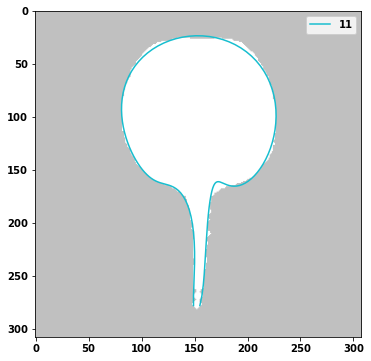

In [16]:
%%time
fl,N = DemoAll(4,samples=31,Nfrom=11,Nto=11,pf=None,withFig=[11])
fall.append(fl)

輪郭線の画素数は、571
11.
CP 5.0, steps:0, etime: 3.10938 err: 1.7886214359
.
CP 2.0, steps:1, etime: 3.75000 err: 1.7788500573
.^.............
CP 1.0, steps:16, etime: 13.60938 err: 0.9896265620
.............E

必要次数は 11
Wall time: 22.3 s


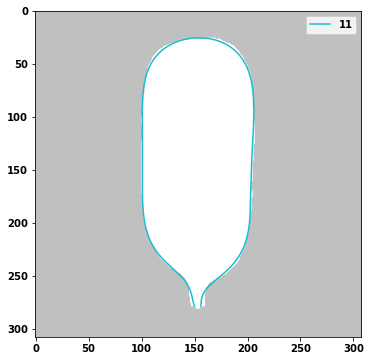

In [17]:
%%time
fl,N = DemoAll(5,samples=31,Nfrom=11,Nto=11,pf=None,withFig=[11])
fall.append(fl)

輪郭線の画素数は、622
11.
CP 5.0, steps:0, etime: 3.09375 err: 3.9626510986
.............
CP 2.0, steps:13, etime: 11.89062 err: 1.9885880869
...........................
CP 1.0, steps:40, etime: 30.45312 err: 0.9998123351
...................E

必要次数は 11
Wall time: 43.1 s


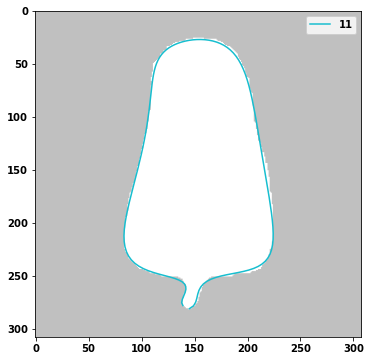

In [18]:
%%time
fl,N = DemoAll(6,samples=31,Nfrom=11,Nto=11,pf=None,withFig=[11])
fall.append(fl)

輪郭線の画素数は、527
11.
CP 5.0, steps:0, etime: 3.15625 err: 2.1875955612
.
CP 2.0, steps:1, etime: 3.82812 err: 1.6089425572
..
CP 1.0, steps:3, etime: 5.14062 err: 0.9053049604
.^..E

必要次数は 11
Wall time: 7.88 s


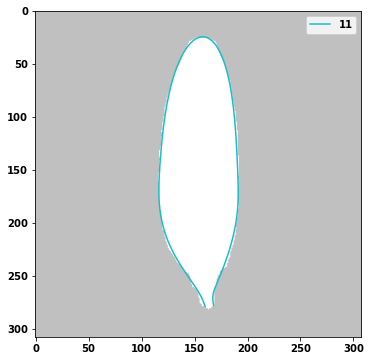

In [19]:
%%time
fl,N = DemoAll(7,samples=31,Nfrom=11,Nto=11,pf=None,withFig=[11])
fall.append(fl)

輪郭線の画素数は、529
11.
CP 5.0, steps:0, etime: 5.62500 err: 2.6286318039
.
CP 2.0, steps:1, etime: 6.84375 err: 1.9366609145
..................................................
CP 1.0, steps:51, etime: 67.23438 err: 0.9985115381
................................................E

必要次数は 11
Wall time: 2min 5s


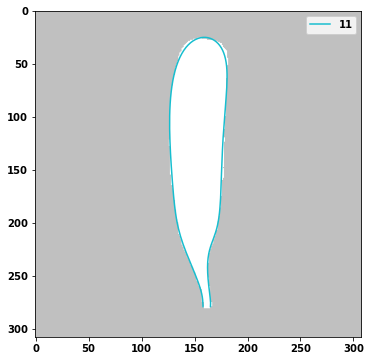

In [20]:
%%time
fl,N = DemoAll(8,samples=64,Nfrom=11,Nto=11,pf=None,withFig=[11])
fall.append(fl)

In [21]:
# 結果の保存
labhome = COLABRDROOT if COLABORATORY else LOCALHOME
resdir = "/res/windows" if platform.system() == "Windows" else "/res"
rd.storePkl(fall,"fall.pkl",labhome+resdir) 

# まとめ

- ほとんどの個体の両側は、６次ベジエ曲線まででかなりいい線の近似が可能である。

- 全周を１本のベジエ曲線で近似することも可能である。その場合は、12か13次ぐらいの次数が必要である。
- 根の細い部分は形状が複雑で多様なので、その部分も正確に近似するのは難しい。
  次数を高く設定すれば近似できるが、そのような部分を捉えることにはあまり意味がないので、予めカットして主要部のみを対象とすることが望ましい。自動処理を重視するならば、一旦粗く近似して後述の中心軸の近似を行った後に幅を基準にカットし、再近似する（２pass）などの解決を図ればよい。

# オーバーフィッティングの対策と判定
標本点を使った曲線あてはめでは、オーバーフィッティング、すなわち標本点以外の部分で曲線が実際とずれるという状況の発生が避けなれない。経験的にも、直感的にも、次数が必要十分な数の前後で発生しがちである。必要十分な十分大きい場合はほとんど発生しないし、十分少なければ標本点間だけでなく標本点でもずれるのでオーバーフィッティングとは言えない（アンダーフィッティング）。ずれが大きいと、これはオーバーフィッティングだと気づくが、きれいにフィッティングできているように見える場合でも標本点間が完璧にフィットするということはない。したがって、あてはめ誤差とは別にオーバフィッティングを判定する客観基準を設ける必要がある。

## オーバーフィッテイングの判定基準
対応点のずれは単純に距離で測ればよいし、区分曲線同士のずれの尺度は点同士ほど単純ではない。輪郭を構成する各点と近似曲線との距離の合計でよいのでは、と思うかもしれないが、それは標本点間隔を短くしたのと同じであり、近似曲線は離散的な輪郭点のすべての近くを通りつつ輪郭から離れた軌跡を描くことがありうる。

ここでは、輪郭点とのずれそのものを測るのはあきらめ、近似曲線上にとられた標本点の対応点間の道のりの長さのみを比較し、実際と近似曲線の各区間長が互いに８割以内に入っっていない区間がひとつでもあればオーバフィッティングとみなすことにした。なお、道のりの長さは各区間の輪郭線と区分曲線をそれぞれ４分割した折れ線の長さで代替するものとした。

輪郭線の長さといってもデジタル画像なので、8連結の画素のチェーンの長さを測ることになり近似的な長さに過ぎない。一方近似曲線は連続関数だが、高次の連続関数なので道のりは数値計算的に求めざるをえない。あまり精度を上げても無駄に計算時間がかかるだけで、結果に大きな差はでない。というか、誤差を許容した扱いをせざるをえない。

当初よく使われる、４分位点を基準としたはずれ値判定（第１四分位点と第３四分位点から四分位範囲の1.5倍の値を判定基準にする方法）やスミルノフ・グラブス検定スミルノフ・グラブス検定による外れ値判定を試してみたが、それぞれ、目視ではきれいにフィットしているような場合でもはずれ値として判定されてしまうことがわかった。また、はずれ値で判定すると、全体的にオーバフィッティングとなっていて区間長の分散が大きい場合、見た目はあきらかに輪郭とずれているのに、はずれ値だと判定されない。


## オーバフィッティング対策
標本点を増やすのが一番簡単であるが、標本点の数を増やすと計算時間がかかってしまう。

勾配法の場合は正則化項を追加するという方法が考えられる。
- 近似曲線の接線方向と標本点間を結ぶ直線の方向ベクトルの差ベクトルの長さの平均値
- 近似曲線上の区分点における２次微係数の平均値
などを正則化項として考えてみた。それぞれそれなりに機能したが効果は個別的であった。

オーバーフィッティングが生じやすいのは、
1. 端点付近
2. 変曲点、特に肥大部と根の境界
であり、特に多いのが端点部分である。

計算量をそれほど増やさずにオーバフィッティングを抑える方法として、オーバーフィッティングが生じやすい箇所だけピンポイントに標本点を追加するという方法が考えられる。残念ながら変曲点の位置を自動判定するのは困難であるが、端点付近なら場所が決まっているので対応可能である。

そこで各フィッティング関数に、moption というオプションを追加し、
- moption = False -> オーバフィッティング対策なし
- moption = True -> 端点とそれに隣接する標本点の中点をフィッティング対象として追加
とした。






In [ ]:
# OverFitting判定　標本点間の異常判定
import scipy.stats as stats

def ovtest(imgnum,N,maxTry,pat,moption=True,snum=65,tover=0.1,tunder=-0.1):
    img = imgs[imgnum]
    conAll = rd.getCntPairWithImg(img, mode=1) # 全周輪郭を得る
    Samples = rd.getSamples(conAll,N=snum,mode='Equidistant')
    bez = rd.BezierCurve(N=N,samples=Samples) # インスタンス生成
    cps, func, (minerror,trynum) = bez.fit1T(mode=1, maxTry=maxTry, withErr=True, withEC=True,prefunc=None,tpara=[], lr=0,  lrP=0, pat=pat, err_th=1.0, threstune=1.00, trial=None, scatter=False, moption=moption)
    odds = isOverFitting(func,bez.ts,conAll,tover=tover,tunder=tunder) 
    rd.drawBez0(img,stt=0.00,end=1.0,bezL=func,cntL=Samples) 
    return odds,func,bez.ts,Samples,conAll

In [ ]:
odds,func,ts,Samples,con = ovtest(8,8,100,100,snum=65,moption=True,tover=0.1,tunder=-0.1)
odds

In [ ]:
odds,func,ts,Samples,con = ovtest(8,9,100,100,snum=65,moption=True,tover=0.1,tunder=-0.1)
odds

In [ ]:
odds,func,ts,Samples,conAll = ovtest(8,9,100,100,snum=65,moption=True,tover=2.0)
odds

In [ ]:
odds,func,ts,Samples,con = ovtest(3,7,100,100,snum=65,moption=True,tover=0.1,tunder=-0.1)
odds

In [ ]:
odds,func,ts,Samples,con = ovtest(3,8,100,100,snum=65,moption=True,tover=0.1,tunder=-0.1)
odds

In [ ]:
odds,r1,r2,r3 = isOverFitting(func,ts,conAll,tover=7)
r1,r2,r3

In [ ]:
odds,func,ts,Samples,conAll = ovtest(8,9,1000,1000,snum=65,moption=True,tover=2.0)
odds

In [ ]:
odds,func,ts,Samples,conAll = ovtest(8,9,3000,1000,snum=65,moption=True,tover=2.0)
odds

In [ ]:
odds,func,ts,Samples,conAll = ovtest(8,20,1000,1000,snum=65,moption=True,tover=2.0)
odds

In [ ]:
odds = ovtest(6,11,100,100,snum=65,moption=True)
odds

In [ ]:
odds,rs = ovtest(3,8,100,100,snum=65,moption=True,alpha=0.3)
odds

In [ ]:
odds,rs = ovtest(8,11,100,100,snum=21,moption=False)
odds

残念ながら、このように明らかにオーバフィッティングしていても、外れ値基準ではオーバフィッティングだと判定できない。 

端部標本点追加の効果

In [ ]:
ovtest(6,11,100,100,False) # オプションなし

In [ ]:
ovtest(6,11,100,100,True) # オプションあり

In [ ]:
ovtest(1,11,100,100,snum=21,moption=False) # オプションなし

In [ ]:
ovtest(1,11,100,100,snum=22,moption=False) # オプションなし

In [ ]:
ovtest(1,11,100,100,snum=23,moption=False) # オプションなし

In [ ]:
ovtest(1,10,300,100,snum=21,moption=False) # オプションなし

In [ ]:
ovtest(1,11,100,100,True) # オプションあり

In [ ]:
ovtest(4,11,100,100,False) # オプションなし

In [ ]:
ovtest(4,11,100,100,True) # オプションあり

In [ ]:
ovtest(4,11,100,100,snum=41,moption=False) # オプションなし

In [ ]:
ovtest(6,11,100,100,snum=65,moption=True) 

# 解説は[こちら](https://colab.research.google.com/gist/iciromaco/a39fad822382b65eda0ec6a2e61981cb/s6_-theory-commentary-fitting-beziercurve-to-sample-points.ipynb)

# 備考

## 曲線あてはめの評価尺度について

曲線あてはめに使うあてはめ誤差としては、通常は曲線と標本点の最短距離を用いるのが妥当であろう。
このノートの実験にもその尺度を用いた。

```'rd.BezierCurve.AsymptoticPriority = 'distance'```

は、その尺度を用いるということの宣言である。

これ以外の尺度として、**'span'** を用意した。

**span**を指定した場合は、標本点が等間隔であるということを前提として、標本点と曲線上の最寄り点との距離の代わりに、曲線上に等間隔に採った点との距離を評価尺度とする。

例として、

```
[[100,100],[100,120],[100,140],[100,160],[100,180],[120,180],[140,180],[160,180],[180,180]]
```

という点列を使って結果を比べてみよう、

### distance

In [ ]:
rd.BezierCurve.debugmode = False
test = np.array([[100,100],[100,120],[100,140],[100,160],[100,180],[120,180],[140,180],[160,180],[180,180]])
rd.BezierCurve.AsymptoticPriority = 'distance'
bez = rd.BezierCurve(N=4,samples=test)
cps,f = bez.fit1()
#cps,f = bez.fit0(bez.ts)
rd.drawBez(img,stt=0.00,end=1.0,bezL=f,cntL=test[::-1])
tl = bez.ts
flx,fly = f
setlx = [float(flx.subs('t',s)) for s in tl]
setly = [float(fly.subs('t',s)) for s in tl]
plt.scatter(setlx,setly,marker='.',color='red')

### span

In [ ]:
rd.BezierCurve.debugmode = False
test = np.array([[100,100],[100,120],[100,140],[100,160],[100,180],[120,180],[140,180],[160,180],[180,180]])
rd.BezierCurve.AsymptoticPriority = 'span'
bez = rd.BezierCurve(N=4,samples=test)
cps,f = bez.fit1()
#cps,f = bez.fit0(bez.ts)
rd.drawBez(img,stt=0.00,end=1.0,bezL=f,cntL=test[::-1])
tl = bez.ts
flx,fly = f
setlx = [float(flx.subs('t',s)) for s in tl]
setly = [float(fly.subs('t',s)) for s in tl]
plt.scatter(setlx,setly,marker='.',color='red')

この例では明らかに span の方があてはめ精度が高い。

ただダイコンのシルエットをいくつか試した限りでは、span は大きな歪を生じることが多かった。